# Создание модели по построению персонализированных предложений для интернет-магазина «В один клик» с целью повышения лояльности клиентов.

### Цели исследования


- Анализ поступивших данных с целью выявления закономерностей и подготовки данных к следующим этапам исследования.



- Разработка модели для прогнозирования вероятности снижения покупательской активности клиента в ближайшие три месяца.


-  Интеграция в проект данных финансового департамента о прибыльности каждого клиента, включая информацию о доходе, который он принес компании за последние три месяца.



- Сегментация и разработка для каждой группы индивидуальных маркетинговых предложений на основе прогнозов модели и данных о прибыльности клиентов


### Ход исследования

- Загрузка предоставленных нам данных и первичное ознакомление с ними.


- Обработка пропусков и дубликатов в данных , а так же поиск аномалий и улучшение качества данных.


- Проведение анализа данных, чтобы выявить закономерности, важные для построения модели МО, а также поиск мультиколлинеарности с целью её устранения.


- Созднание "пайнлайна" с применением различных **моделей МО** и анализ результатов лучшей модели. 


- Анализ важности признаков более всего оказавших влияние на итоговый результат.


- Распределение покупателей по группам на основании предсказаний лучшей **модели МО**.


- Итоговый вывод и описание преимуществ модели показавшей лучший результат.


### Описание переменных представленных в данных.

#### **`market_file.csv`**

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

`id` — номер покупателя в корпоративной базе данных.

`Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».

`Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».

`Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.

`Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.

`Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.

`Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.

`Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.

`Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.

`Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.

`Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.

`Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.

`Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.




#### **`market_money.csv`**

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.


`id` — номер покупателя в корпоративной базе данных.

`Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.

`Выручка` — сумма выручки за период.




#### **`market_time.csv`**

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.


`id` — номер покупателя в корпоративной базе данных.

`Период` — название периода, во время которого зафиксировано общее время.
минут — значение времени, проведённого на сайте, в минутах.



#### **`money.csv`**

Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.


`id` — номер покупателя в корпоративной базе данных.

`Прибыль` — значение прибыли.

### Техническая секция

#### Импорт библиотек

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import shap
import phik
import warnings
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, \
    recall_score, confusion_matrix, precision_recall_curve, classification_report, roc_auc_score, make_scorer, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### Функции созданные в ходе выполнения проекта.

In [4]:
def check_data_dubmiss(df, df_name='DataFrame'):
    """
    Анализирует DataFrame на дубликаты и пропущенные значения.
    Возвращает единый отчет в виде DataFrame с категориями.

    Параметры:
    - df: pandas DataFrame для проверки
    - df_name: название DataFrame для отчета

    Возвращает:
    - Единый DataFrame с отчетом
    """
    report_parts = []

    # 1. Общая информация
    info_df = pd.DataFrame({
        'Категория': ['Общая информация'],
        'Параметр': ['Название датафрейма'],
        'Значение': [df_name],
        'Детали': [f'Размер : {df.shape[0]} x {df.shape[1]}']
    })
    report_parts.append(info_df)

    # 2. Дубликаты
    duplicates = df.duplicated().sum()
    duplicates_df = pd.DataFrame({
        'Категория': ['Дубликаты', 'Дубликаты'],
        'Параметр': ['Всего дубликатов', 'Примеры дубликатов'],
        'Значение': [duplicates, duplicates > 0],
        'Детали': ['', f"Первые {min(5, duplicates)} примеров" if duplicates > 0 else '']
    })
    report_parts.append(duplicates_df)

    # 3. Пропущенные значения по столбцам
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    
    if missing.sum() > 0:
        missing_df = pd.DataFrame({
            'Категория': ['Пропущенные значения'] * len(missing),
            'Параметр': missing.index,
            'Значение': missing.values,
            'Детали': [f"{pct:.2f}%" for pct in missing_pct.values]
        })
        missing_df = missing_df[missing_df['Значение'] > 0]
        report_parts.append(missing_df)

    # 4. Итог по пропущенным значениям
    total_missing_df = pd.DataFrame({
        'Категория': ['Пропуски'],
        'Параметр': ['Всего пропущенных значений'],
        'Значение': [missing.sum()],
        'Детали': [f"{missing.sum() / df.size:.2%} от всех ячеек"]
    })
    report_parts.append(total_missing_df)

    report = pd.concat(report_parts, ignore_index=True)

    if duplicates > 0:
        duplicates_examples = df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist()).head()
        report.at[4, 'Детали'] = str(duplicates_examples.to_dict('records'))

    return report

In [5]:
sns.set_style('whitegrid')
sns.set_palette('RdYlBu')
def graph_cat(df, columns, title, xlabel):
    """
    Визуализирует категориальные данные с помощью круговой диаграммы и столбчатой диаграммы.

    Параметры:
    -----------
    df : pandas.DataFrame
        DataFrame, содержащий данные.
    columns : str
        Название столбца с категориальными данными для визуализации.
    title : str
        Заголовок графика.
    xlabel : str
        Подпись оси X.

    
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    df[columns].value_counts().plot(kind='pie', y='count', x='subscription_type',
                           colors=['grey', 'orange', 'lightblue', 'yellow'],ax=ax[0], autopct='%1.1f%%')
    ax[0].set_title('Процентное ' + title)
    ax[0].set_ylabel(' ')

    sns.countplot(data=df, y=columns, ax=ax[1], palette=['grey', 'orange', 'lightblue', 'yellow'])
    #sns.countplot(data=df, x=columns, ax=ax[1], palette=['grey', 'orange', 'lightblue'], orient='h')
    ax[1].set_title('Колличественное '+ title)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Тип переменной')

In [6]:
def graph_num(df, columns, title, xlabel, bins=30):
    """
    Визуализирует числовые данные с помощью гистограммы и boxplot.

    Параметры:
    -----------
    df : pandas.DataFrame
        DataFrame, содержащий данные для анализа.
    columns : str
        Название столбца с числовыми данными, которые будут визуализированы.
    title : str
        Заголовок графика (добавляется к описанию гистограммы и boxplot).
    xlabel : str
        Подпись оси X для гистограммы.
    bins : int, optional
        Количество интервалов (бинов) для гистограммы. По умолчанию 30.

    
    """
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    sns.histplot(data=df, x=columns, kde=True, color='blue', bins=bins, ax=ax[0])
    ax[0].set_title('Гистограмма признака '+ title)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('Кол-во')
    
    sns.boxplot(data=df[columns], orient='h', ax=ax[1])
    ax[1].set_title('Разброс значений признака '+ title)
    ax[1].set_xlabel('Значения')
    ax[1].set_ylabel(' ')

## Загрузка полученных данных.

### Market_file.csv

Загрузим таблицу с общей информацией о поведении пользователей на странице интернет-магазина.

In [7]:
df_market = pd.read_csv('/datasets/market_file.csv')
display(df_market.head(5))
display(df_market.describe().T)
df_market.info()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
Длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
Средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
Неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Данные выглядят нормально без явных аномалий.

### Market_money.csv

Импортируем таблицу с информацией об общей выручке которую пользователь принес интернет-магазину.

In [8]:
df_money_market = pd.read_csv('/datasets/market_money.csv')
display(df_money_market.head(5))
display(df_money_market.describe().T)
df_money_market.info()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
Выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Подозрение вызывает максимальное значение "Выручки" в **106862.2** при среднем значении переменной в **5025.69**.

Подробней рассмотрим эту аномалию на этапе предобработки данных.

### Market_time.csv

Добавим таблицу с информацией о времени проведенном пользователем на сайте.

In [9]:
df_time = pd.read_csv('/datasets/market_time.csv')
display(df_time.head(5))
display(df_time.describe().T)
df_time.info()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


При первом рассмотрении видимых аномалий в данных обнаружить не удалось.

### Money.csv

Загрузим информацию об общей прибыли принесенной каждым пользователем интернет-магазина.

In [10]:
df_money = pd.read_csv('/datasets/money.csv', sep=';', decimal='.')
display(df_money.head(5))
display(df_money.describe().T)
df_money.info()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.5,375.421985,215348.0,215672.75,215997.5,216322.25,216647.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


В данных обнаружилась ошибка в виде несоответствия типа столбца "Прибыль" который содержит числовые данные но представлен типом "object"

Исправим это и рассмотрим на распределение значений этой переменной в следующем блоке исследования.


### Вывод по блоку

- Были обнаружены незначительные аномалии в данных а именно *аномально высокое значение числовой переменной "Выручка"* и *несоответствие типов данных некоторых переменных.*


- В остальном данные не вызывают каких либо подозрений , устранением выявленных ошибок и более глубоким анализом представленных данных займемся ниже на этапе предобработки данных.


## Предобработка данных.

### Устранение выявленных аномалий.

#### Анализ переменной "Выручка" в датасете *df_money_market*

Посмотрим на распределение базовых значений стобца **"Выручка"**

In [11]:
df_money_market['Выручка'].describe().to_frame()

,Выручка
count,3900.000000
mean,5025.696051
std,1777.704104
min,0.000000
25%,4590.150000
50%,4957.500000
75%,5363.000000
max,106862.200000


Максимальное значение **106862** выглядит как ошибка записи в единицах измерения либо же сбой при выгрузке данных.

Проанализируем **квартиль 75%** на наличие похожих значений.

In [12]:
display(len(df_money_market[df_money_market['Выручка'] > 5363]))
df_money_market[df_money_market['Выручка'] > 5363].describe()

974

,id,Выручка
count,974.000000,974.000000
mean,215965.445585,5987.082854
std,375.396646,3268.621823
min,215350.000000,5363.400000
25%,215630.500000,5527.850000
50%,215966.000000,5757.650000
75%,216282.000000,6122.025000
max,216641.000000,106862.200000


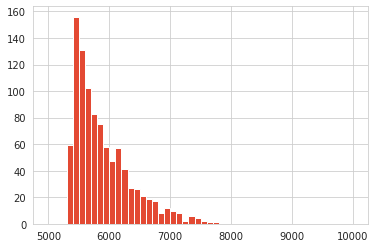

In [13]:
df_money_market[df_money_market['Выручка'] > 5363]['Выручка'].hist(bins=50, range=(5000, 10000));

Из гистограммы видно что значения более **7800** в данных не представлено.

Отсортируем значения по полученной нами информации для того что бы быть уверенными в наших выводах.


In [14]:
df_money_market[df_money_market['Выручка'] > 8000]

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


Видим что значение в 106862.2 действительно является аномальным.

Для получения дополнительных сведений в подтверждение нашей догадки , получим данные по пользователю с *id* **215380**.


In [15]:
df_money_market[df_money_market['id'] == 215380]

,id,Период,Выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


Думаю данных говорящих в пользу того что в данных присутствует аномалия , более чем достаточно.

Такое значения *Прибыли* в целом возможно , но что бы не искажать данные и не получить искаженные предсказания **модели МО** , примем решение о замене этого значения на среднее значение прибыли по предыдущим месяцам для данного конкретного пользователя.

In [16]:
df_money_market.loc[98, 'Выручка'] = ((df_money_market.loc[96, 'Выручка'] + df_money_market.loc[97, 'Выручка']) / 2)
display(df_money_market.loc[98].to_frame())
df_money_market.describe()

,98
id,215380
Период,текущий_месяц
Выручка,5564.0


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,4999.722154
std,375.325686,706.966984
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,7799.400000


Видим что удалось полностью устранить аномалию и улучшить качество наших данных.

#### Изменение типа данных столбца *Прибыль* в датасете *df_money*

На этапе первичного ознакомления с данными была замечена ошибка типа данных.

In [17]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


In [18]:
df_money['Прибыль'] = df_money['Прибыль'].str.replace(',', '.').astype(float)

In [19]:
df_money['Прибыль'].describe().to_frame()

,Прибыль
count,1300.000000
mean,3.996631
std,1.013722
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000


Как видим проблему удалось успешно устранить , данные в столбце **"Прибыль"** представлены нормально.

#### Приведение названий столбцов к единому стандарту

Для дальнейшего удобства используем единый стандарт записи к названиям столбцов наших наборов данных.

Изменим все заглавные буквы на строчные и заменим пробелы на "_".

In [20]:
df_market.columns = df_market.columns.str.lower().str.replace(' ', '_')
df_market.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [21]:
df_money_market.columns = df_money_market.columns.str.lower().str.replace(' ', '_')
df_money_market

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
...,...,...,...
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0


In [22]:
df_time.columns = df_time.columns.str.lower().str.replace(' ', '_')
df_time

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
...,...,...,...
2595,216645,текущий_месяц,18
2596,216646,предыдцщий_месяц,18
2597,216646,текущий_месяц,7
2598,216647,текущий_месяц,10


Удалось заметить опечатку в переменной **период** , а именно *предыдцщий_месяц* учитывая другие наборы данных имеллось в виду *предыдущий_месяц* исправим это.

In [23]:
df_time['период'] = df_time['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')
df_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

Как видим удалось устранить эту опечатку.

In [24]:
df_money.columns = df_money.columns.str.lower().str.replace(' ', '_')
df_money

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
...,...,...
1295,216643,4.44
1296,216644,6.11
1297,216645,3.29
1298,216646,4.03


### Проверка на дубликаты и пропущенные значения.

Для анализа наших наборов данных используем автоматизированную функцию созданную в начале проекта в советующем [разделе](#Функции-созданные-в-ходе-выполнения-проекта.).

#### df_market

In [25]:
check_data_dubmiss(df_market, df_name='df_market')

,Категория,Параметр,Значение,Детали
0,Общая информация,Название датафрейма,df_market,Размер : 1300 x 13
1,Дубликаты,Всего дубликатов,0,
2,Дубликаты,Примеры дубликатов,False,
3,Пропуски,Всего пропущенных значений,0,0.00% от всех ячеек


#### df_money_market

In [26]:
type(df_money_market)

pandas.core.frame.DataFrame

In [27]:
check_data_dubmiss(df_money_market, df_name='df_money_market')

,Категория,Параметр,Значение,Детали
0,Общая информация,Название датафрейма,df_money_market,Размер : 3900 x 3
1,Дубликаты,Всего дубликатов,0,
2,Дубликаты,Примеры дубликатов,False,
3,Пропуски,Всего пропущенных значений,0,0.00% от всех ячеек


#### df_time

In [28]:
check_data_dubmiss(df_time, df_name='df_time')

,Категория,Параметр,Значение,Детали
0,Общая информация,Название датафрейма,df_time,Размер : 2600 x 3
1,Дубликаты,Всего дубликатов,0,
2,Дубликаты,Примеры дубликатов,False,
3,Пропуски,Всего пропущенных значений,0,0.00% от всех ячеек


#### df_money

In [29]:
check_data_dubmiss(df_money, df_name='df_money')

,Категория,Параметр,Значение,Детали
0,Общая информация,Название датафрейма,df_money,Размер : 1300 x 2
1,Дубликаты,Всего дубликатов,0,
2,Дубликаты,Примеры дубликатов,False,
3,Пропуски,Всего пропущенных значений,0,0.00% от всех ячеек


### Вывод по блоку.


- Нам удалось полностью устранить выявленные на этапе первичного ознакомления аномалии , что позволило повысить качество наших данных.


- Проверка на дубликаты и пропущенные значения , ничего не выявила.

## Исследовательский анализ данных

Поочередно рассмотрим все переменные представленные в данных , на предмет обнаружения аномалий не выявленных на предыдущих этапах исследования и выялвления закономерностей.

### df_market

In [30]:
df_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

#### Анализ категориальных переменных

#### Покупательская активность

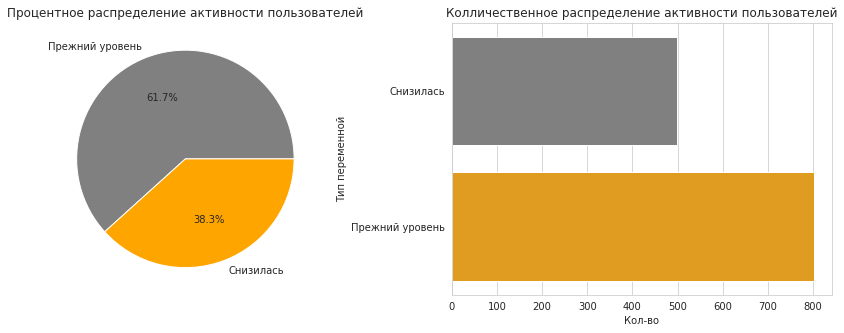

In [31]:
graph_cat(df_market, 'покупательская_активность', 'распределение активности пользователей', 'Кол-во')

Данные распределены нормально , сильного дисбаланса классов не наблюдается.

#### Тип сервиса

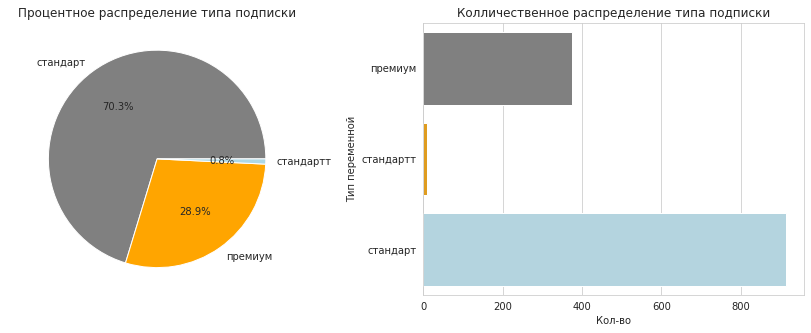

In [32]:
graph_cat(df_market, 'тип_сервиса', 'распределение типа подписки', 'Кол-во')

При детальном рассмотрении переменной обнаружился дефект в написании переменной **стандартт** , исправим это.

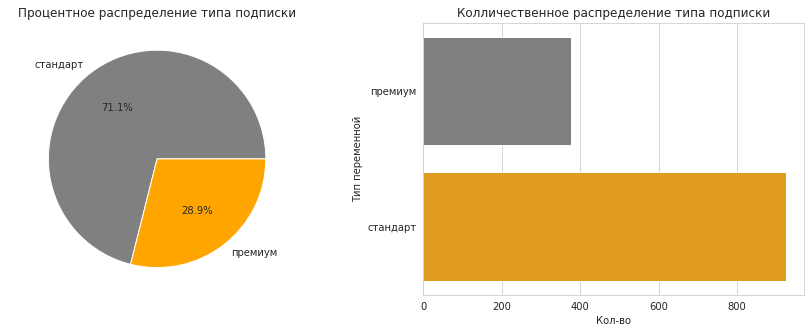

In [33]:
df_market['тип_сервиса'] = df_market['тип_сервиса'].str.replace('стандартт', 'стандарт')
graph_cat(df_market, 'тип_сервиса', 'распределение типа подписки', 'Кол-во')

Опечатка устранена , видим что основная группа пользователей использует базовый тариф **стандарт**

#### Разрешить сообщать 

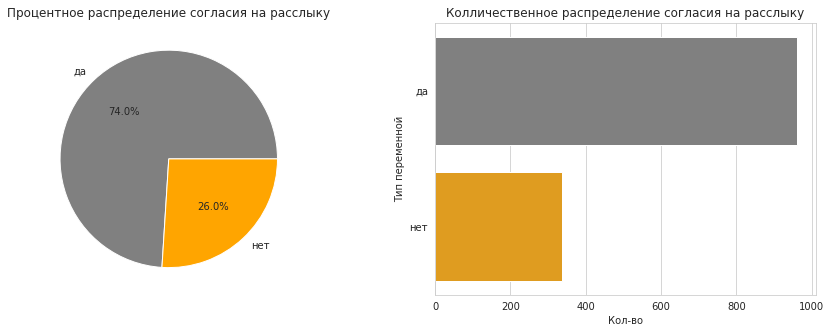

In [34]:
graph_cat(df_market, 'разрешить_сообщать', 'распределение согласия на расслыку', 'Кол-во')

Видим что основная часть покупателей подписана на рассылку предложений от интернет-магазина.

#### Популярная_категория

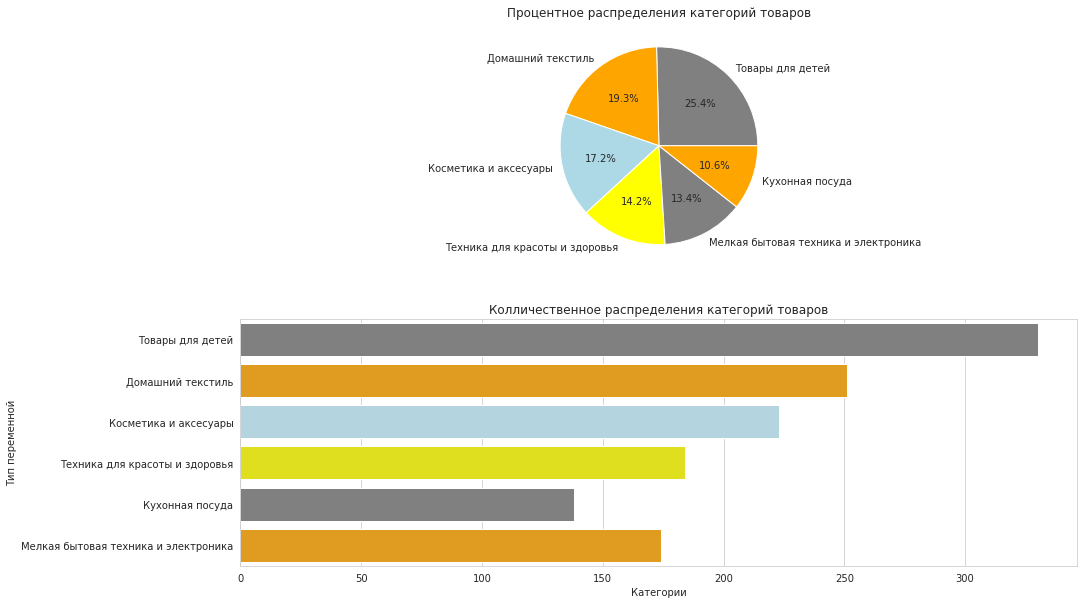

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

df_market['популярная_категория'].value_counts().plot(kind='pie', y='count', x='популярная_категория',
                           colors=['grey', 'orange', 'lightblue', 'yellow'],ax=ax[0], autopct='%1.1f%%')
ax[0].set_title('Процентное распределения категорий товаров')
ax[0].set_ylabel(' ')

sns.countplot(data=df_market, y='популярная_категория', ax=ax[1], palette=['grey', 'orange', 'lightblue', 'yellow'])
    
ax[1].set_title('Колличественное распределения категорий товаров')
ax[1].set_xlabel('Категории')
ax[1].set_ylabel('Тип переменной');

Категории товаров в целом распределились нормально , незначительном лидеров по предпочтениям пользователей выступили товары из категории **Товары для детей**

### Анализ количественных переменных

#### Маркет_актив_6_мес

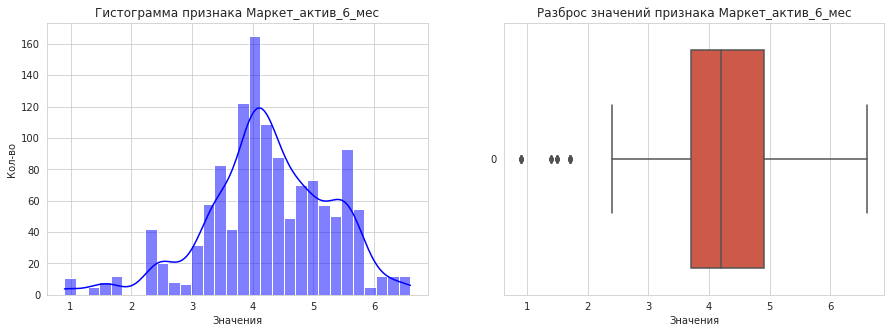

In [36]:
graph_num(df_market, 'маркет_актив_6_мес', 'Маркет_актив_6_мес', 'Значения')

За исключением нескольких просадок , данные распределились нормально.

#### Маркет_актив_тек_мес

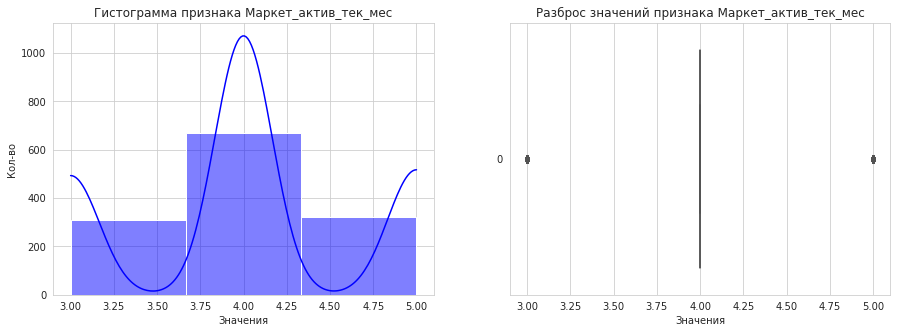

In [37]:
graph_num(df_market, 'маркет_актив_тек_мес', 'Маркет_актив_тек_мес', 'Значения', bins=3)

In [38]:
df_market['маркет_актив_тек_мес'].value_counts()

4    669
5    323
3    308
Name: маркет_актив_тек_мес, dtype: int64

Данные в представленной переменой распределены нормально , видно что среднее количество коммуникаций в месяц равно **4**.

#### Длительность

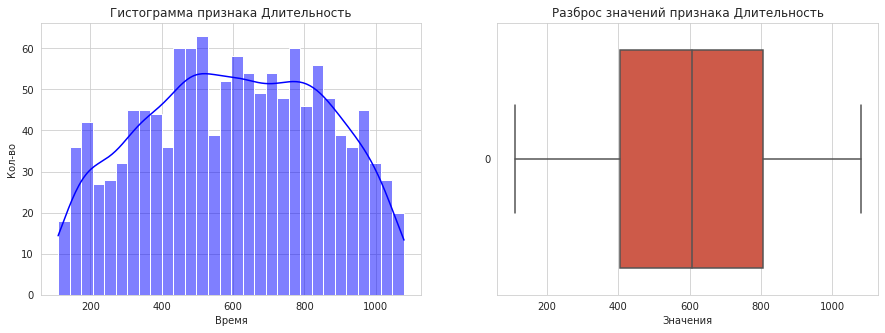

In [39]:
graph_num(df_market, 'длительность', 'Длительность', 'Время')

Аномалий в данных не выявленно.

#### Акционные_покупки

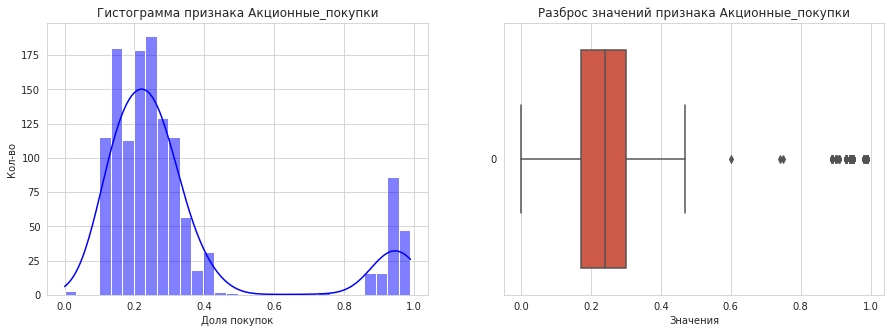

In [40]:
graph_num(df_market, 'акционные_покупки', 'Акционные_покупки', 'Доля покупок')

In [41]:
ac = len(df_market[df_market['акционные_покупки'] > 0.5])
print(f"Число пользователей с высоким процентов акционных покупок : {ac}")
print(f"Доля пользователей с высоким процентом акционных покупок: {(ac/len(df_market) * 100):.1f}%")

Число пользователей с высоким процентов акционных покупок : 168
Доля пользователей с высоким процентом акционных покупок: 12.9%


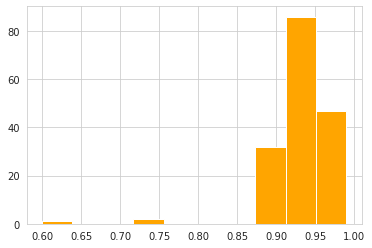

In [42]:
df_market[df_market['акционные_покупки'] > 0.5]['акционные_покупки'].hist(bins=10, color='orange');

Видим что пользователи разделились на две группы , одна из них группа покупателей обладающая "умеренным интересом к акционным товарам" и вторая группа покупатели которые интересуются исключительно акционными предложениями и не проявляет интереса к остальным группам товаров.

Возможно это окажется полезным на этапе обучения **модели МО** , для создания дополнительного категориального признака.


#### Средний_просмотр_категорий_за_визит

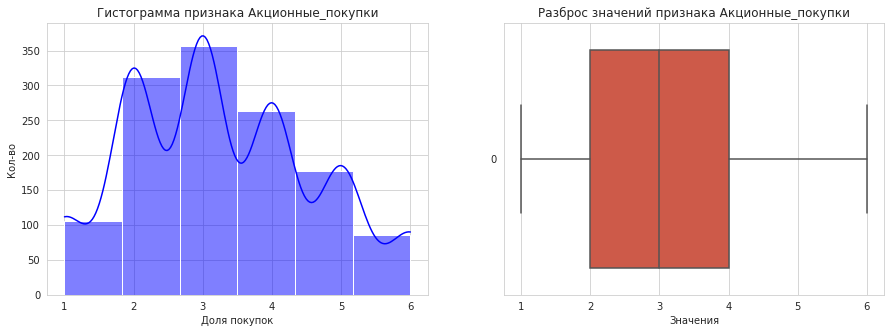

In [43]:
graph_num(df_market, 'средний_просмотр_категорий_за_визит', 'Акционные_покупки', 'Доля покупок', bins=6)

Данные в переменной не вызывают подозрений.

#### Неоплаченные_продукты_штук_квартал

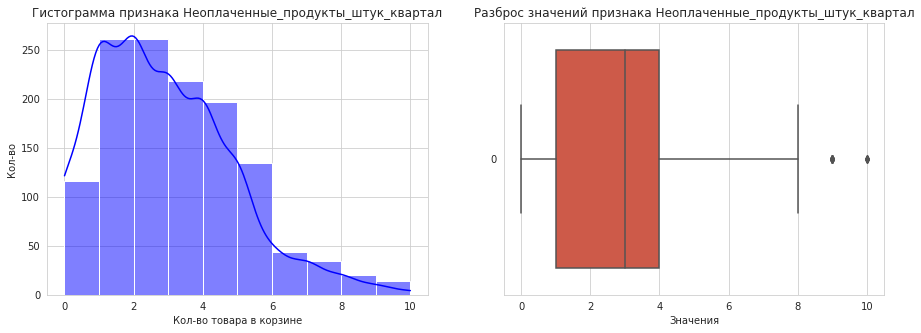

In [44]:
graph_num(df_market, 'неоплаченные_продукты_штук_квартал', 
          'Неоплаченные_продукты_штук_квартал', 'Кол-во товара в корзине', bins=10)

Основная часть значений распределились нормально , значения в **9 и 10** товаров в корзине в целом вписываться в описание переменной и не являються аномалией.

#### Ошибка_сервиса

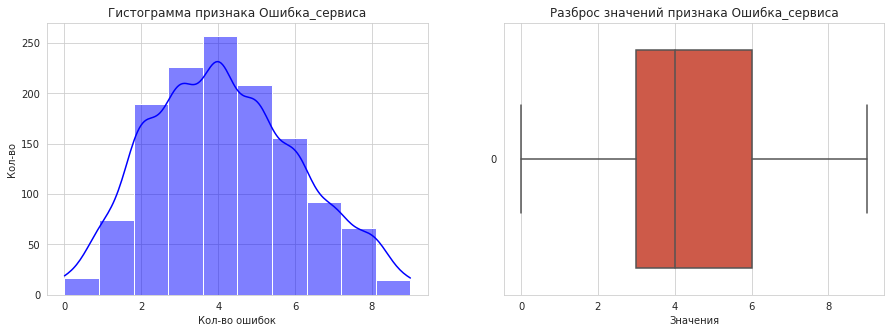

In [45]:
graph_num(df_market, 'ошибка_сервиса', 'Ошибка_сервиса', 'Кол-во ошибок', bins=10)

Данные обладают абсолютно нормальным распределением.

#### Страниц_за_визит

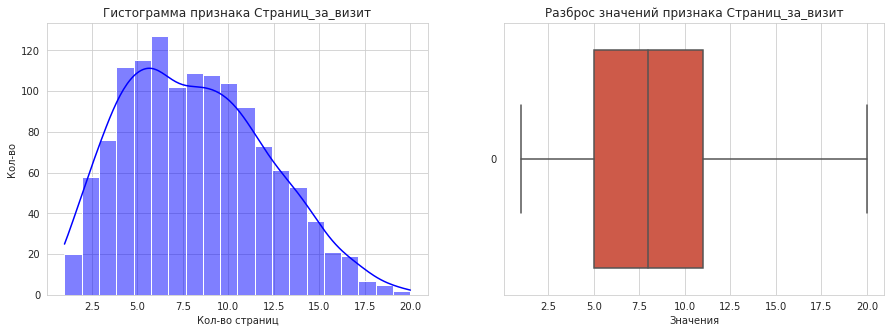

In [46]:
graph_num(df_market, 'страниц_за_визит', 'Страниц_за_визит', 'Кол-во страниц', bins=20)

Аномалий в количестве просмотренных страниц не  выявлено.

### df_money_market

Датасет имеет всего 2 интересующих нас переменных рассмотрим их ниже.

#### Период

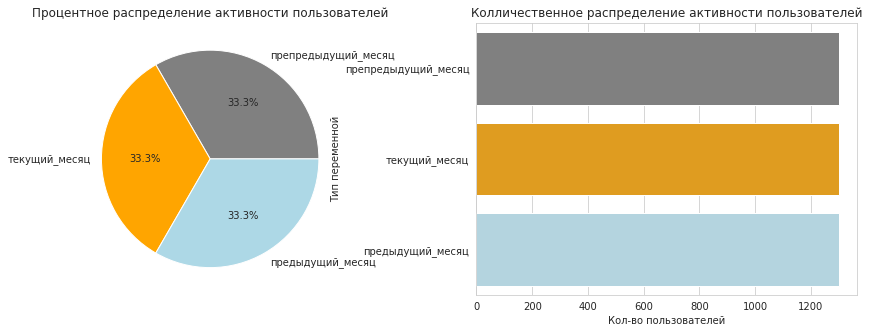

In [47]:
graph_cat(df_money_market, 'период', 'распределение активности пользователей', 'Кол-во пользователей')

Видим что категориальные переменные распределились нормально.

#### Выручка

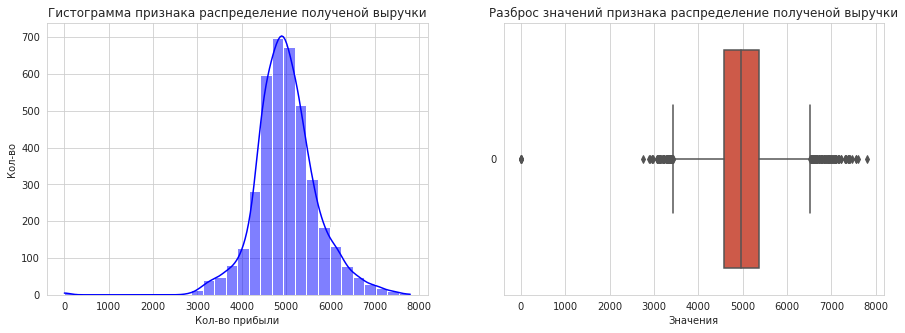

In [48]:
graph_num(df_money_market, 'выручка', 'распределение полученой выручки', 'Кол-во прибыли', bins=30)

Числовые показатели выручки распределены нормально.

###  df_time

Набор данных так же содержит всего 2 переменных , проанализируем их ниже.

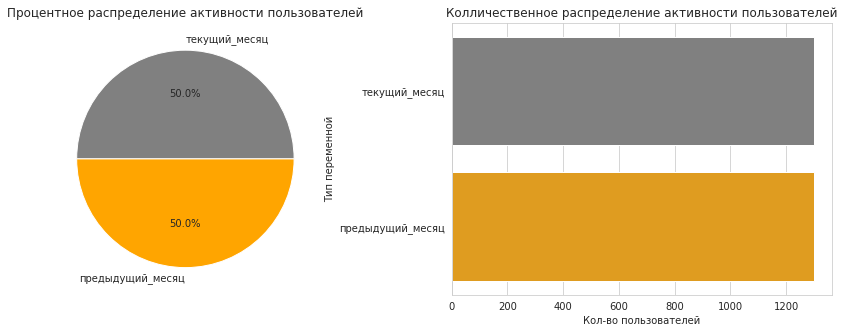

In [49]:
graph_cat(df_time, 'период', 'распределение активности пользователей', 'Кол-во пользователей')

Данные переменной распределились ровно пополам.

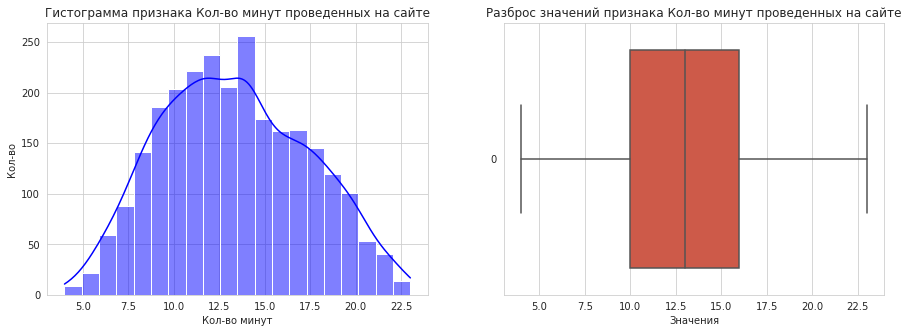

In [50]:
graph_num(df_time, 'минут', 'Кол-во минут проведенных на сайте', 'Кол-во минут', bins=20)

Рассмотренная переменная обладает нормальным распределением.

### df_money

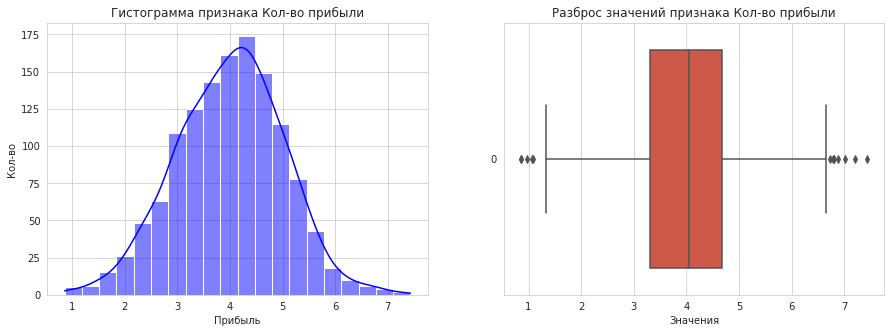

In [51]:
graph_num(df_money, 'прибыль', 'Кол-во прибыли', 'Прибыль', bins=20)

Данные распределены нормально.

In [52]:
df_market

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7


### Рассмотрим как распределились переменные относительно текущей "покупательской активности"

Рассмотрим как распределились числовые переменные в абсолютных и процентных значениях.

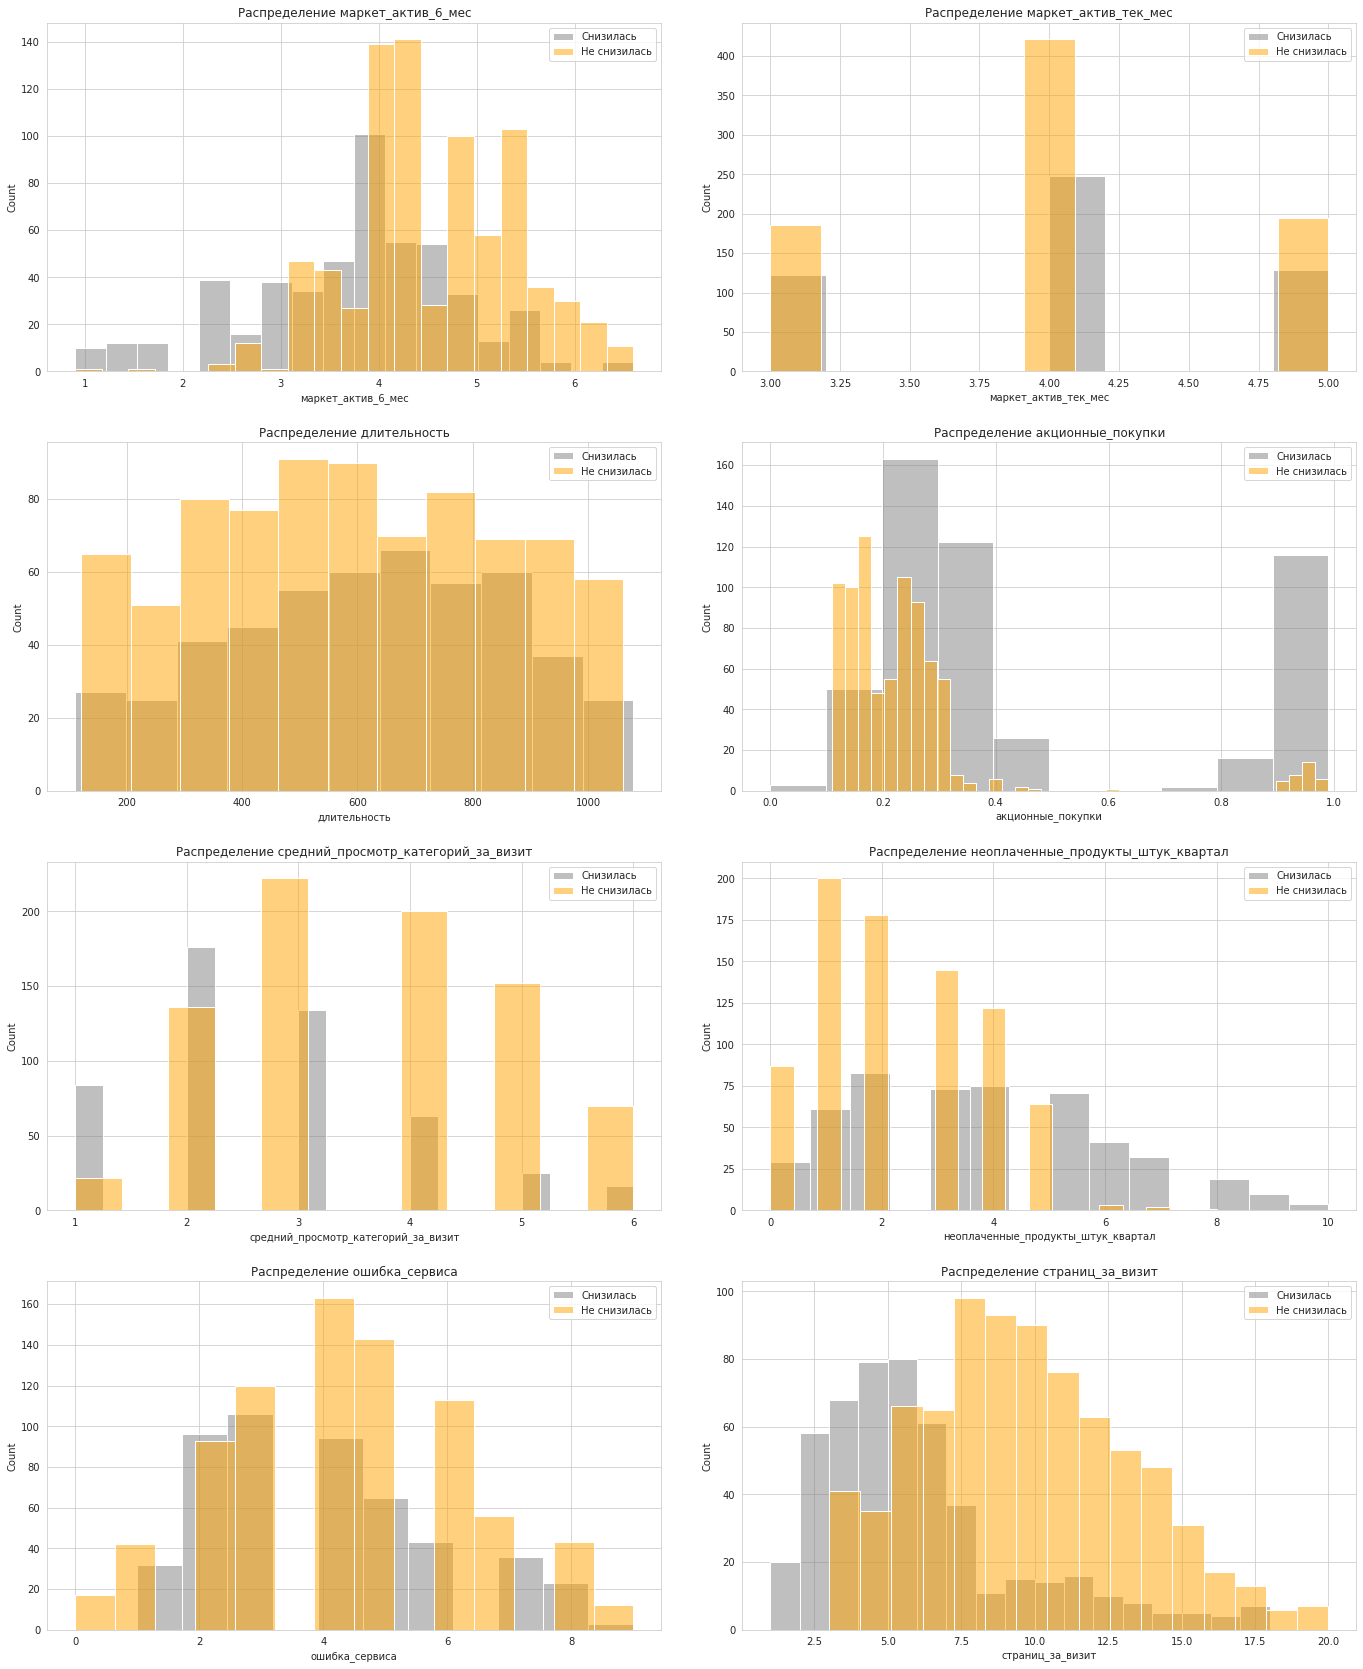

In [53]:
dec = df_market[df_market['покупательская_активность'] == 'Снизилась']
no_dec = df_market[df_market['покупательская_активность'] != 'Снизилась']
num_cols = df_market.select_dtypes(include=['number']).columns.drop('id')

fig, ax = plt.subplots(nrows=(len(num_cols) + 1) // 2, ncols=2, figsize=(20, 6 * ((len(num_cols) + 1) // 2)))
                         
fig.tight_layout(pad=5.0)

ax = ax.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(dec[col], color='grey', label='Снизилась', alpha=0.5, ax=ax[i],)
    sns.histplot(no_dec[col], color='orange', label='Не снизилась', alpha=0.5, ax=ax[i],)
    ax[i].set_title(f'Распределение {col}')
    ax[i].legend()

if len(num_cols) % 2 != 0:
    ax[-1].axis('off')

plt.show()

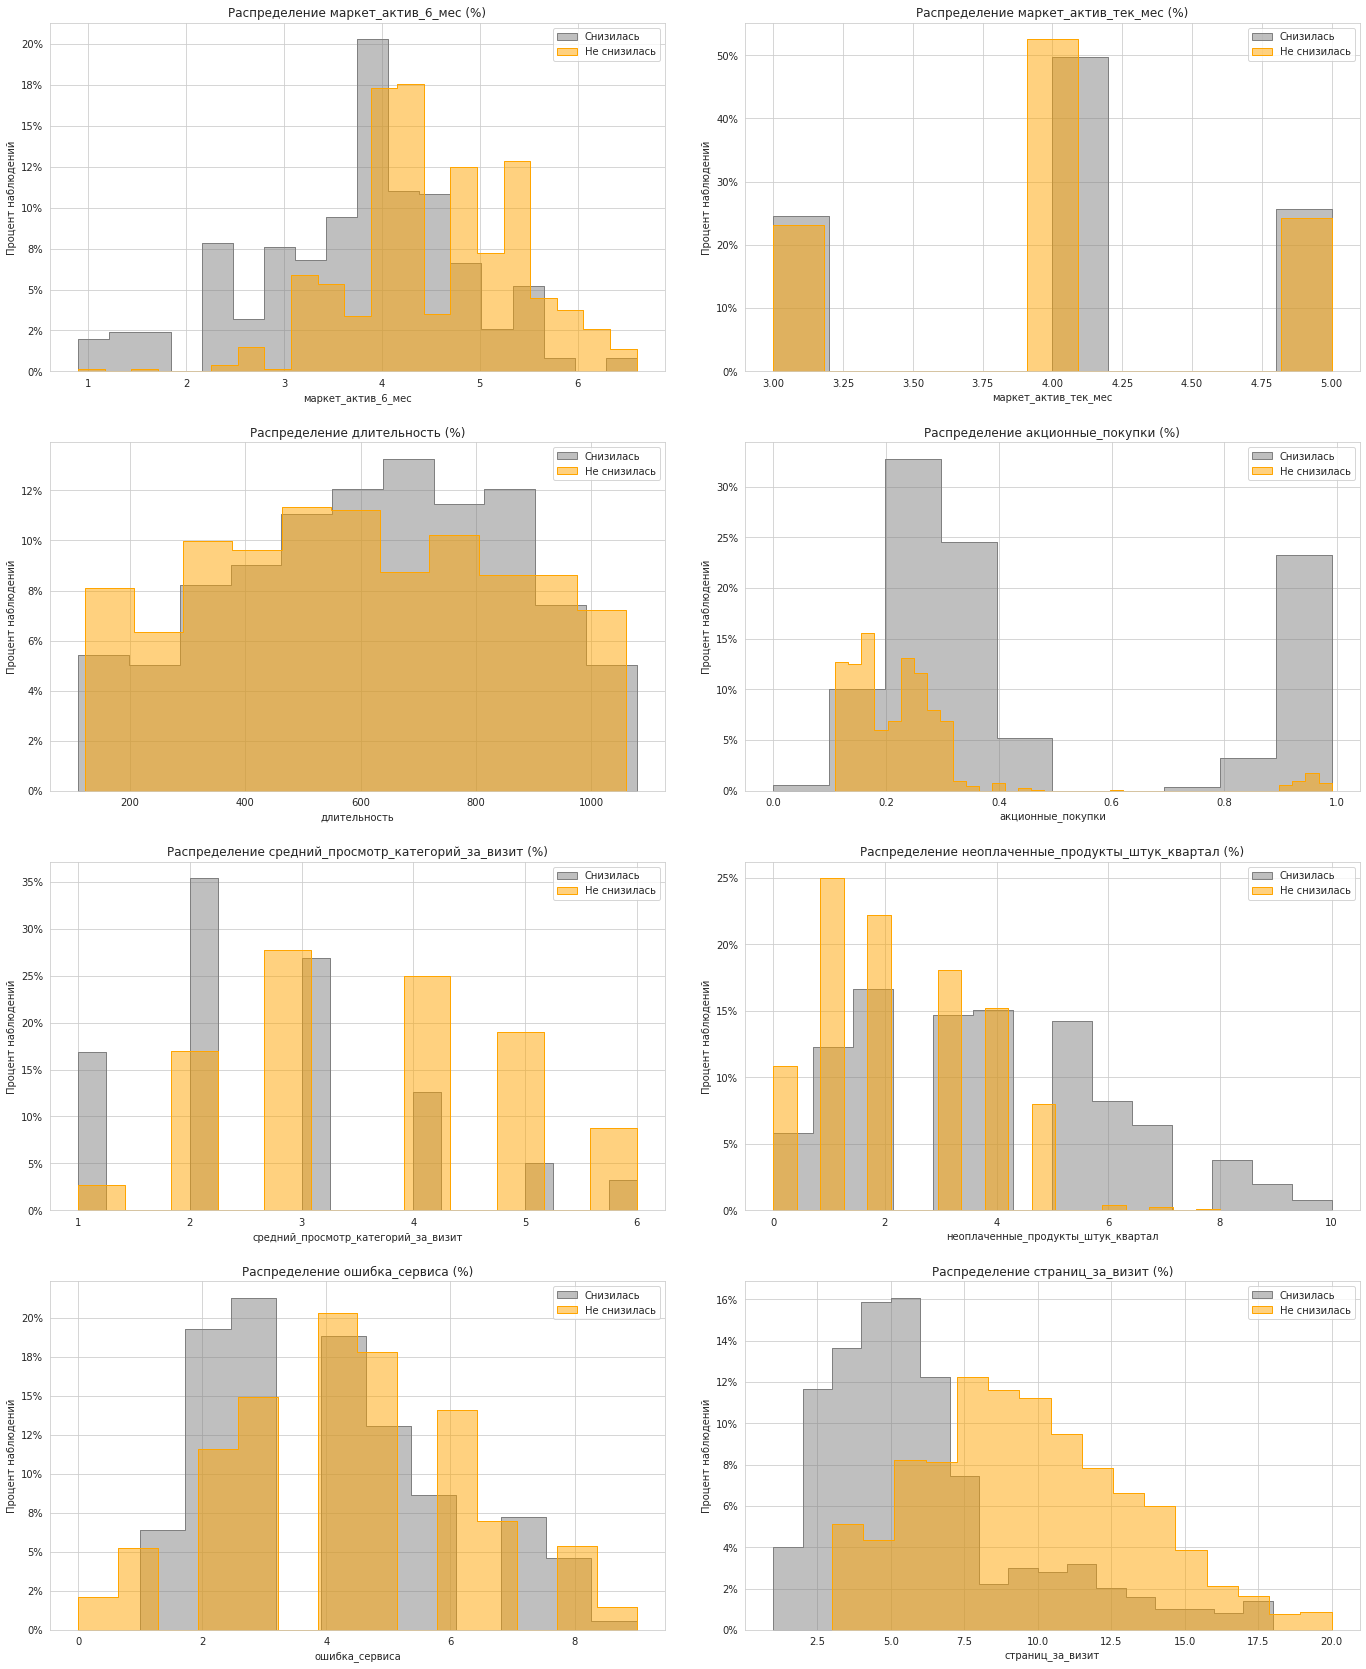

In [54]:
fig, ax = plt.subplots(nrows=(len(num_cols) + 1) // 2, ncols=2, 
                      figsize=(20, 6 * ((len(num_cols) + 1) // 2)))
fig.tight_layout(pad=5.0)
ax = ax.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(dec[col], color='grey', label='Снизилась', 
                 alpha=0.5, ax=ax[i], stat='probability', 
                 element='step', fill=True, common_norm=False)
    sns.histplot(no_dec[col], color='orange', label='Не снизилась', 
                 alpha=0.5, ax=ax[i], stat='probability',
                 element='step', fill=True, common_norm=False)
    
    ax[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
    
    ax[i].set_title(f'Распределение {col} (%)')
    ax[i].set_ylabel('Процент наблюдений')
    ax[i].legend()

if len(num_cols) % 2 != 0:
    ax[-1].axis('off')

plt.show()

Проанализируем распределение категориальных категорий в абсолютных и процентных значениях.

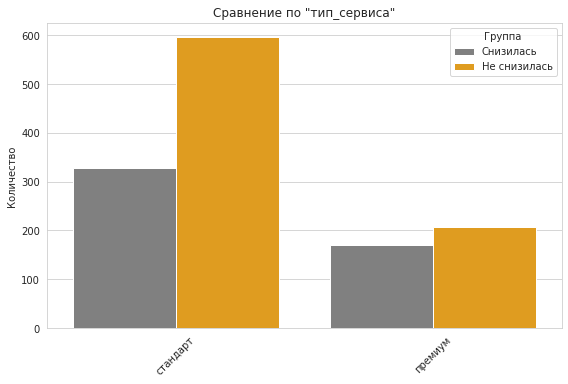

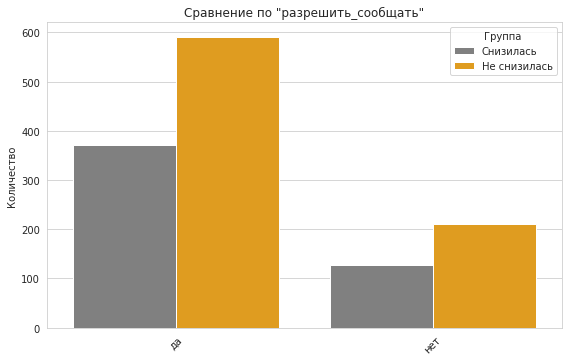

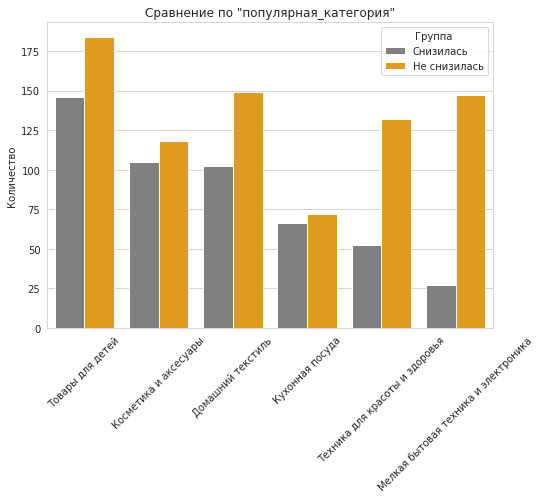

In [55]:
cat_cols = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

for col in cat_cols:
    df_decr = dec[col].value_counts().reset_index()
    df_decr.columns = ['category', 'count']
    df_decr['group'] = 'Снизилась'
    
    df_nodecr = no_dec[col].value_counts().reset_index()
    df_nodecr.columns = ['category', 'count']
    df_nodecr['group'] = 'Не снизилась'
    
    df_combined = pd.concat([df_decr, df_nodecr])
    
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_combined, x='category', y='count', hue='group', 
                palette={'Снизилась': 'grey', 'Не снизилась': 'orange'})
    
    plt.title(f'Сравнение по "{col}"')
    plt.xlabel('')
    plt.ylabel('Количество')
    plt.legend(title='Группа')
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

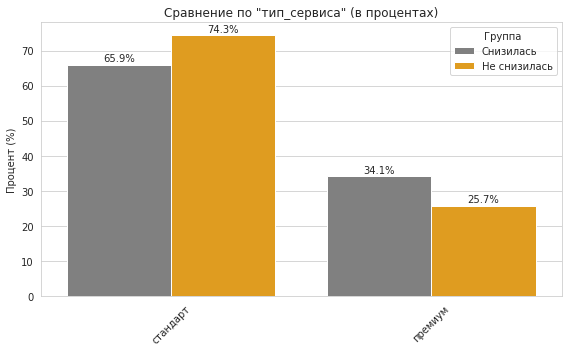

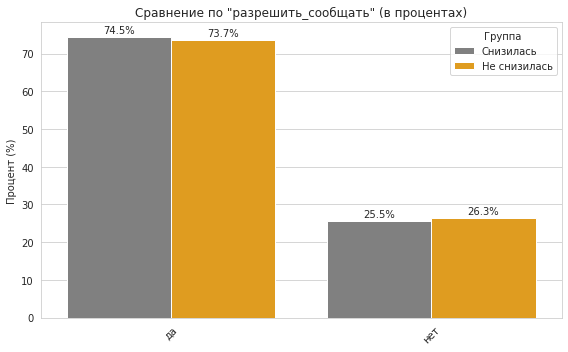

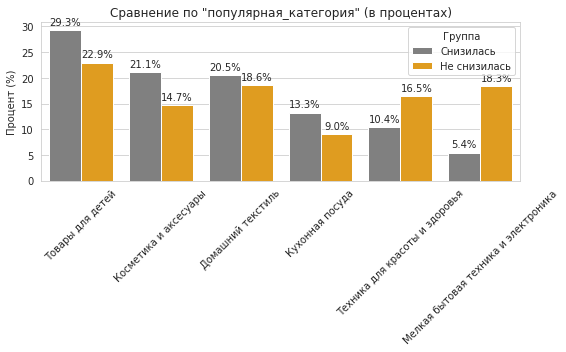

In [56]:
cat_cols = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

for col in cat_cols:
    df_decr = (dec[col].value_counts(normalize=True) * 100).reset_index()
    df_decr.columns = ['category', 'percent']
    df_decr['group'] = 'Снизилась'
    
    df_nodecr = (no_dec[col].value_counts(normalize=True) * 100).reset_index()
    df_nodecr.columns = ['category', 'percent']
    df_nodecr['group'] = 'Не снизилась'
    
    df_combined = pd.concat([df_decr, df_nodecr])
    
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=df_combined, x='category', y='percent', hue='group', 
                    palette={'Снизилась': 'grey', 'Не снизилась': 'orange'})
    
    plt.title(f'Сравнение по "{col}" (в процентах)')
    plt.xlabel('')
    plt.ylabel('Процент (%)')
    plt.legend(title='Группа')
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Вывод**


Проанализировав значения двух групп пользователей по признаку "покупательской активности" , можно сделать следующие выводы :


- В числовых показателях у группы со "снижением активности" заметно падение значений в таких категориях как *'средний_просмотр_категорий_за_визит' и 'страниц_за_визит'*


- Так же удалось заметить особый паттерн поведения в таких категориях как **'неоплаченные_продукты_штук_квартал' и 'акционные_покупки'** , чем выше количественное значение в этих категориях тем больше клиентов имеют статус "снижение". Это подтверждает выдвинутую нами ранее гипотезу о разделении пользователей на "обычных" и "покупателей акционных товаров". В периоды без акции активность таких пользователей идет на значительный спад.


- В категориальных признаках особой разницы в поведении покупателей не наблюдается.

На этапе проведенного нами исследовательского анализа , можно сделать следующее предположение о том , что основным индикатором нажигающегося снижения активности выступает потеря интереса со стороны покупателя (снижение кол-ва просмотров за сессию) а так длительное отсутствие акционных ивентов , что вполне логично и вписывается в привычную картину данного сегмента рынка.



### Отбор активных пользователей за последние 3 месяца.

Отберем пользователей по **id** , которые производили покупки на протяжении последних 3 месяцев.

In [57]:
pp_month = df_money_market.query("период == 'препредыдущий_месяц' & выручка !=0")['id']
p_month = df_money_market.query("период == 'предыдущий_месяц' & выручка !=0")['id']
month = df_money_market.query("период == 'текущий_месяц' & выручка !=0")['id']
active_buyers = set(pp_month) & set(p_month) & set(month)
active_buyers_df = pd.DataFrame(sorted(active_buyers), columns=['id'])
display(active_buyers_df.head(10))
print(f"Количество уникальных пользователей : {len(df_money_market['id'].unique())}")
print(f"Количество активных пользователей на протяжении 3 месяцев : {len(active_buyers_df)}")

,id
0,215349
1,215350
2,215351
3,215352
4,215353
5,215354
6,215355
7,215356
8,215358
9,215360


Количество уникальных пользователей : 1300
Количество активных пользователей на протяжении 3 месяцев : 1297


**Составим портрет пользователя не проявляющего достаточной активности за последние 3 мес**

Составим описательную статистику по этим пользователям.

In [58]:
non_actv = df_money[~df_money['id'].isin(active_buyers_df['id'])]['id'].to_list()
df_market[df_market['id'].isin(non_actv)]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
9,215357,Снизилась,стандарт,да,3.9,5,154,0.0,Техника для красоты и здоровья,3,3,9,5
11,215359,Снизилась,стандарт,да,4.6,5,110,0.0,Домашний текстиль,4,2,4,2


In [59]:
df_market[df_market['id'].isin(non_actv)].describe().T

,count,mean,std,min,25%,50%,75%,max
id,3.0,215354.666667,5.859465,215348.0,215352.50,215357.0,215358.00,215359.0
маркет_актив_6_мес,3.0,3.966667,0.602771,3.4,3.65,3.9,4.25,4.6
маркет_актив_тек_мес,3.0,5.000000,0.000000,5.0,5.00,5.0,5.00,5.0
длительность,3.0,128.333333,22.898326,110.0,115.50,121.0,137.50,154.0
акционные_покупки,3.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
средний_просмотр_категорий_за_визит,3.0,4.333333,1.527525,3.0,3.50,4.0,5.00,6.0
неоплаченные_продукты_штук_квартал,3.0,2.333333,0.577350,2.0,2.00,2.0,2.50,3.0
ошибка_сервиса,3.0,4.666667,4.041452,1.0,2.50,4.0,6.50,9.0
страниц_за_визит,3.0,4.000000,1.732051,2.0,3.50,5.0,5.00,5.0


Сравним с аналогичными значениями активной группы пользователей.

Посмотрим для начала на значения всей группы.

In [60]:
df_market[df_market['id'].isin(active_buyers_df['id'])].describe().T

,count,mean,std,min,25%,50%,75%,max
id,1297.0,215998.986893,374.578554,215349.00,215675.00,215999.00,216323.0,216647.00
маркет_актив_6_мес,1297.0,4.254433,1.015618,0.90,3.70,4.20,4.9,6.60
маркет_актив_тек_мес,1297.0,4.009252,0.696048,3.00,4.00,4.00,4.0,5.00
длительность,1297.0,602.993832,249.101456,121.00,410.00,607.00,806.0,1079.00
акционные_покупки,1297.0,0.320547,0.249657,0.11,0.17,0.24,0.3,0.99
средний_просмотр_категорий_за_визит,1297.0,3.267540,1.354623,1.00,2.00,3.00,4.0,6.00
неоплаченные_продукты_штук_квартал,1297.0,2.841172,1.973451,0.00,1.00,3.00,4.0,10.00
ошибка_сервиса,1297.0,4.184271,1.950973,0.00,3.00,4.00,6.0,9.00
страниц_за_визит,1297.0,8.186584,3.977061,1.00,5.00,8.00,11.0,20.00


Проведем рандомизированный эксперимент выбрав 10 случайных пользователей из общего датафрейма и посмотрим на значения.

In [61]:
df_market[df_market['id'].isin(active_buyers_df['id'])].sample(10).describe().T

,count,mean,std,min,25%,50%,75%,max
id,10.0,216134.700,373.109472,215562.00,215879.250,216117.000,216482.00,216617.00
маркет_актив_6_мес,10.0,4.420,1.189584,2.40,3.500,4.600,4.90,6.30
маркет_актив_тек_мес,10.0,4.100,0.737865,3.00,4.000,4.000,4.75,5.00
длительность,10.0,653.500,297.967280,271.00,430.000,598.500,949.25,1030.00
акционные_покупки,10.0,0.306,0.250120,0.13,0.155,0.275,0.30,0.98
средний_просмотр_категорий_за_визит,10.0,3.900,1.663330,1.00,3.000,4.000,5.00,6.00
неоплаченные_продукты_штук_квартал,10.0,3.900,1.852926,2.00,3.000,3.000,4.75,7.00
ошибка_сервиса,10.0,4.300,1.567021,1.00,4.000,4.500,5.00,7.00
страниц_за_визит,10.0,6.300,2.830391,2.00,5.000,6.500,8.75,10.00


Видим что отличия между группами пользователей , в основном проявляться в переменной "длительность" которая отражает кол-во дней с момента регистрации.

Посмотрим на поведение клиентов не вошедших в список активных пользователей.

In [62]:
non_active_df = df_money_market[~df_money_market['id'].isin(active_buyers_df['id'])]
non_active_df

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
27,215357,текущий_месяц,5986.3
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
33,215359,текущий_месяц,4735.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Руководствуясь полученной информацией о том что данные пользователи недавно зарегистрировались , и проявили активность в одно и тоже время "текущий_месяц", можно предположить что такое поведение является обычным для новых пользователей.

### Вывод по блоку


- В процессе детального рассмотрения значений переменных в наших наборах данных , была обнаружена и устранена опечатка в датасете **df_market**. В остальном данные представлены нормально и готовы к обучению модели.


- Так же удалось установить число активных пользователей за последние 3 месяца в **1297** от общего числа в **1300**. Так же на основании полученной информации мы сделали вывод что возможно это не является аномалией.


- На этапе совместного анализа категориальных и числовых признаков , мы сделали предположение о том что основным критерием для определения предстоящего снижения полустелькой активности , выступает снижение кол-ва просмотров за сессию. Проверим это предположение после того как получим предсказания модели МО.


## Объединение таблиц

Объединим все наши наборы данных в единый датасет для последующего обучения **модели МО** , развернем наши данные при помощи сводных таблиц что бы добиться одинакового количества строк для дальнейшего объединения.

In [63]:
df_money_market_pv = df_money_market.pivot_table(index='id', columns='период', values='выручка').add_prefix('выручка_')
df_money_market_pv.head(5)

период,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [64]:
df_time_pv = df_time.pivot_table(index='id', columns='период', values='минут').add_prefix('минут_')
df_time_pv.head(5)

период,минут_предыдущий_месяц,минут_текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


Выполним промежуточное обьединение.

In [65]:
df_full = pd.merge(df_money_market_pv, df_time_pv, on='id', how='outer')
df_full.head(5)

период,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,
215348,0.0,0.0,3293.1,13,14
215349,5216.0,4472.0,4971.6,12,10
215350,5457.5,4826.0,5058.4,8,13
215351,6158.0,4793.0,6610.4,11,13
215352,5807.5,4594.0,5872.5,8,11


Финальное обьединение подготовленных датасетов.

In [66]:
df_full = pd.merge(df_full, df_market, on='id', how='outer')
df_full.head(5)

,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,0.0,0.0,3293.1,13,14,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,5216.0,4472.0,4971.6,12,10,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,5457.5,4826.0,5058.4,8,13,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,6158.0,4793.0,6610.4,11,13,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,5807.5,4594.0,5872.5,8,11,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


### Удаление "неактивных" пользователей.

In [67]:
df_full.shape

(1300, 18)

In [68]:
df_full = df_full[~df_full['id'].isin(non_actv)].reset_index(drop=True)
display(df_full.shape)
df_full.head(10)

(1297, 18)

,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215349,5216.0,4472.0,4971.6,12,10,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
1,215350,5457.5,4826.0,5058.4,8,13,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
2,215351,6158.0,4793.0,6610.4,11,13,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
3,215352,5807.5,4594.0,5872.5,8,11,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
4,215353,4738.5,5124.0,5388.5,10,10,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
5,215354,5685.0,4503.0,5869.6,11,12,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
6,215355,3263.0,4749.0,3772.6,12,10,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
7,215356,4146.5,4433.0,4566.4,6,7,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
8,215358,3488.0,4727.0,4209.5,14,10,Снизилась,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4
9,215360,5304.5,5555.0,5834.9,9,6,Снизилась,премиум,да,3.9,3,623,0.35,Кухонная посуда,3,1,4,7


Видим что удаление прошло нормально.

### Вывод по блоку

- Мы получили наборы данных , разной размерности и привели их к единому стандарту развернув информацию из них в разные столбцы при помощи сводных таблиц и выполнили финальное объединение , создав датафрейм **df_full**.


- Так же очистили данные от *неактивных* пользователей , что бы улучшить будущие предсказания модели МО.


## Корреляционный анализ


Для дальнейшего удобства создадим переменные содержащие категориальные и числовые переменные нашего датасета **df_full**

In [69]:
num_cols = df_full.drop('id', axis=1).select_dtypes(include=['int64', 'float64']).columns
num_cols

Index(['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц',
       'выручка_текущий_месяц', 'минут_предыдущий_месяц',
       'минут_текущий_месяц', 'маркет_актив_6_мес', 'маркет_актив_тек_мес',
       'длительность', 'акционные_покупки',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [70]:
cat_cols = df_full.select_dtypes(exclude='number').columns
cat_cols

Index(['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'популярная_категория'],
      dtype='object')

### Построим классическую матрицу "Спирмана" корреляции для числовых признаков.

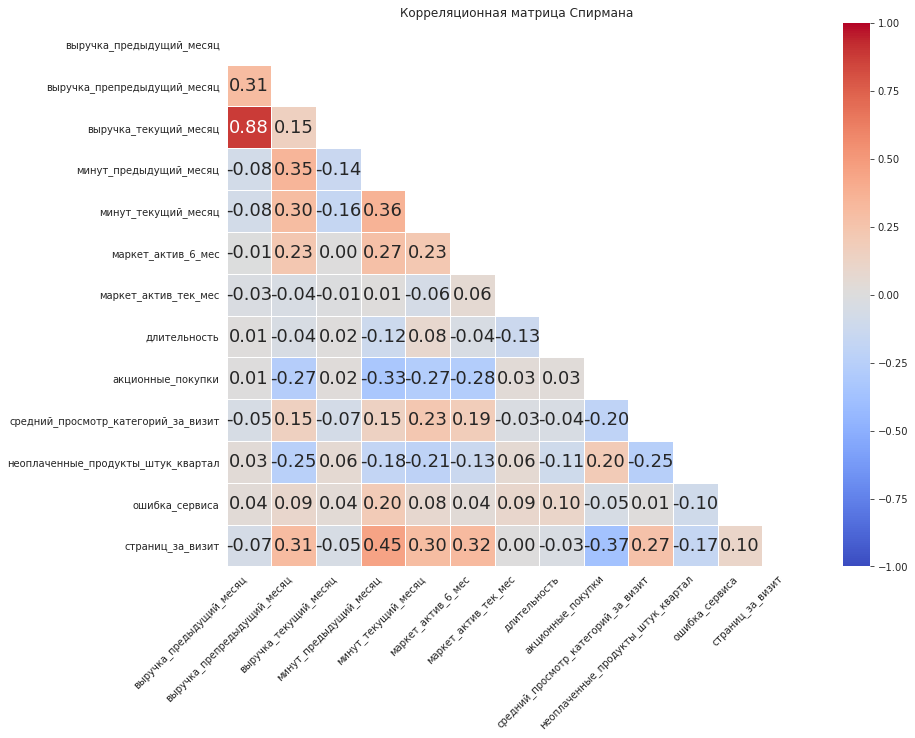

In [71]:
tri = np.triu(np.ones_like(df_full[num_cols].corr(), dtype=bool))
plt.figure(figsize=(13, 10))
heatmap = sns.heatmap(
    df_full[num_cols].corr('spearman'), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5,  
    vmin=-1, vmax=1, annot_kws={"size": 18}, mask=tri)     
plt.title("Корреляционная матрица Спирмана")
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.show()

### Так же используя библиотеку phik , построим еще одну матрицу для всех признаков.

interval columns not set, guessing: ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']


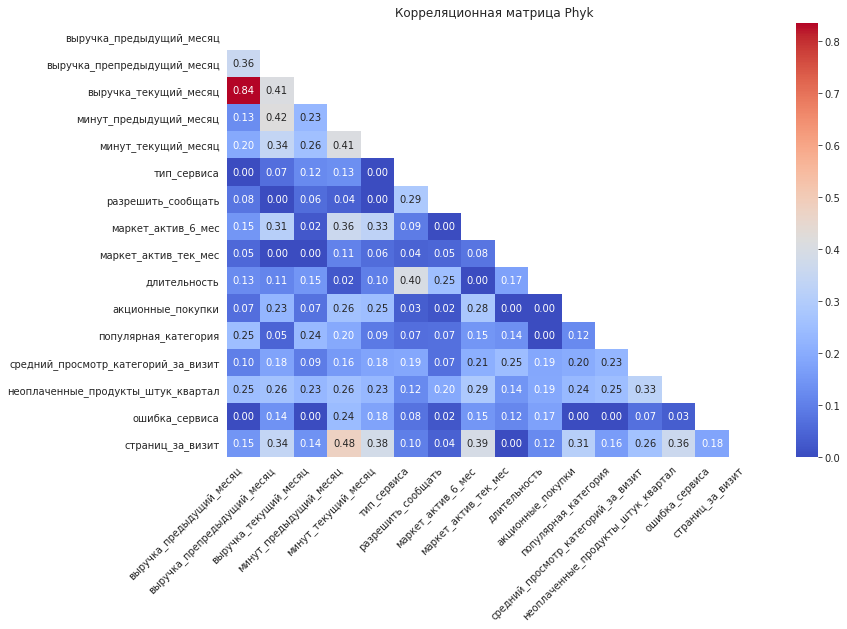

In [72]:
phik_matrix = df_full.drop(['id', 'покупательская_активность'], axis=1).phik_matrix()
tri = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=tri);
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.title("Корреляционная матрица Phyk")
plt.show()

### Для дополнительной оценки  мультиколлинеарности воспользуемся библиотекой **vif**

In [73]:
num_cols = df_full.select_dtypes(include='number').columns.drop('id')
vif_num = df_full[num_cols].assign(const=1)
vif_data = pd.DataFrame()
vif_data["feature"] = df_full[num_cols].columns
vif_data["VIF"] = [variance_inflation_factor(vif_num, i) for i in range(len(df_full[num_cols].columns))]
vif_data.sort_values(by="VIF", ascending=False)

,feature,VIF
0,выручка_предыдущий_месяц,4.257304
2,выручка_текущий_месяц,3.889624
1,выручка_препредыдущий_месяц,1.612591
3,минут_предыдущий_месяц,1.526976
12,страниц_за_визит,1.417590
4,минут_текущий_месяц,1.320945
5,маркет_актив_6_мес,1.221564
10,неоплаченные_продукты_штук_квартал,1.198202
8,акционные_покупки,1.186183
9,средний_просмотр_категорий_за_визит,1.178631


In [74]:
num_cols = df_full.select_dtypes(include='number').columns.drop('id')

In [75]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = df_full[num_cols]
vif_data = vif_data.assign(const=1)
vif = pd.DataFrame({
    'feature': num_cols,
    'VIF': [variance_inflation_factor(vif_data.values, i) for i in range(len(num_cols))]})
display(vif)

,feature,VIF
0,выручка_предыдущий_месяц,4.257304
1,выручка_препредыдущий_месяц,1.612591
2,выручка_текущий_месяц,3.889624
3,минут_предыдущий_месяц,1.526976
4,минут_текущий_месяц,1.320945
5,маркет_актив_6_мес,1.221564
6,маркет_актив_тек_мес,1.044478
7,длительность,1.099467
8,акционные_покупки,1.186183
9,средний_просмотр_категорий_за_визит,1.178631


### Вывод по блоку


- В ходе анализа значений , мультиколлинеарности установлено не было.


- Для обучения модели на начальном этапе оставим все признаки и после получения результатов примем решении об исключении или же добавлении новых данных в наш датасет.

## Построение пайплайна.

### Разнесем переменные по категориям в зависимости от типа данных.

In [76]:
df_full.head(5)

,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215349,5216.0,4472.0,4971.6,12,10,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
1,215350,5457.5,4826.0,5058.4,8,13,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
2,215351,6158.0,4793.0,6610.4,11,13,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
3,215352,5807.5,4594.0,5872.5,8,11,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
4,215353,4738.5,5124.0,5388.5,10,10,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4


In [77]:
num_cols = ['выручка_текущий_месяц','выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 
            'минут_предыдущий_месяц', 'минут_текущий_месяц', 
            'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
            'акционные_покупки', 'средний_просмотр_категорий_за_визит',
            'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']

cat_cols = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']


### Создадим выборки для обучения.

In [78]:
RS = 42
TS = 0.25

X = df_full.drop(['id', 'покупательская_активность'], axis=1)
y = df_full['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TS, random_state=RS) 
                                                
X_train.head(5)

,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
545,4828.0,4822.0,4952.8,13,9,стандарт,нет,4.3,4,460,0.16,Техника для красоты и здоровья,2,1,3,6
266,4798.5,4377.0,5184.6,10,14,стандарт,да,0.9,4,728,0.90,Домашний текстиль,2,3,2,4
327,5252.0,4876.0,5055.7,19,16,стандарт,да,5.2,4,205,0.11,Техника для красоты и здоровья,2,3,2,5
798,5354.0,4820.0,5946.8,19,17,стандарт,да,5.7,4,290,0.16,Мелкая бытовая техника и электроника,5,4,3,12
59,4839.0,4248.0,4607.6,6,4,стандарт,да,3.0,3,1048,0.89,Товары для детей,4,5,3,1


### Пустой пайплайн

In [79]:
# Создадим заглущки , а параметры будем перебирать в models
numeric_transformer = Pipeline([
    ('scaler', 'passthrough'),  
    ('preprocessor', None)      
])

cat_transformer = Pipeline([
    ('encoder', 'passthrough'),  
    ('preprocessor', None)      
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', cat_transformer, cat_cols) 
    ],
    remainder='drop',
    transformer_weights=None)

### Параметры моделей

In [80]:
models = {
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=RS),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
            'preprocessor__cat__encoder': [OneHotEncoder(drop='first', sparse=False), 
                          OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)],
            'classifier__max_depth': [3, 5, 7, None],
            'classifier__min_samples_split': [2, 5, 10]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=RS),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
            'preprocessor__cat__encoder': [OneHotEncoder(drop='first', sparse=False), 
                          OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)],
            'classifier__C': [0.01, 0.1, 1, 10],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['liblinear']
        }
    },
    'SVC': {
        'model': SVC(random_state=RS, probability=True),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
            'preprocessor__cat__encoder': [OneHotEncoder(drop='first', sparse=False), 
                          OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)],
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf'],
            'classifier__gamma': ['scale', 'auto']
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
            'preprocessor__cat__encoder': [OneHotEncoder(drop='first', sparse=False), 
                          OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)],
            'classifier__n_neighbors': [3, 5, 7, 10],  
        }
    }
}

### Перебор моделей

Для оценки качества будем использовать метрику *accuracy* , так как заказчик поставил задачу бинарной классификации и целевой признак не имеет явного дисбаланса классов.

In [81]:
# KNN выдавал предупреждение разных версий
warnings.filterwarnings("ignore", category=FutureWarning) 
results = {}
for name, config in models.items():

    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', config['model'])
    ])
    
    # Перебор по GridSearch
    grid = GridSearchCV(
        pipeline,
        config['params'],
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    results[name] = {
        'best_model': grid.best_estimator_,
        'best_params': grid.best_params_,
        'best_score': grid.best_score_,
        'test_score': accuracy_score(y_test, grid.predict(X_test))
    }
    
    print(f"{name} completed. Best Accuracy: {grid.best_score_:.4f}, Test Accuracy: {results[name]['test_score']:.4f}")
for name, res in results.items():
    print(f"{name}:")
    print(f"Best scaler: {res['best_params']['preprocessor__num__scaler']}")
    print(f"Best scaler: {res['best_params']['preprocessor__cat__encoder']}")

    print(f"Test Accuracy: {res['test_score']:.4f}\n")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
DecisionTree completed. Best Accuracy: 0.8704, Test Accuracy: 0.8277
Fitting 5 folds for each of 48 candidates, totalling 240 fits
LogisticRegression completed. Best Accuracy: 0.8837, Test Accuracy: 0.8677
Fitting 5 folds for each of 72 candidates, totalling 360 fits
SVC completed. Best Accuracy: 0.8910, Test Accuracy: 0.8677
Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNeighborsClassifier completed. Best Accuracy: 0.8837, Test Accuracy: 0.8646
DecisionTree:
Best scaler: StandardScaler()
Best scaler: OneHotEncoder(drop='first', sparse=False)
Test Accuracy: 0.8277

LogisticRegression:
Best scaler: StandardScaler()
Best scaler: OneHotEncoder(drop='first', sparse=False)
Test Accuracy: 0.8677

SVC:
Best scaler: StandardScaler()
Best scaler: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
Test Accuracy: 0.8677

KNeighborsClassifier:
Best scaler: StandardScaler()
Best scaler: OrdinalEncoder(h

In [82]:
pd.set_option('display.max_colwidth', None)

results_df = pd.DataFrame({
    'Model': results.keys(),
    'Train Accuracy': [res['best_score'] for res in results.values()],
    'Test Accuracy': [res['test_score'] for res in results.values()],
    'Best Parameters': [res['best_params'] for res in results.values()]
}).sort_values(by='Test Accuracy', ascending=False)

display(results_df)


,Model,Train Accuracy,Test Accuracy,Best Parameters
1,LogisticRegression,0.883743,0.867692,"{'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'preprocessor__cat__encoder': OneHotEncoder(drop='first', sparse=False), 'preprocessor__num__scaler': StandardScaler()}"
2,SVC,0.890960,0.867692,"{'classifier__C': 0.1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf', 'preprocessor__cat__encoder': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__num__scaler': StandardScaler()}"
3,KNeighborsClassifier,0.883748,0.864615,"{'classifier__n_neighbors': 10, 'preprocessor__cat__encoder': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__num__scaler': StandardScaler()}"
0,DecisionTree,0.870378,0.827692,"{'classifier__max_depth': 5, 'classifier__min_samples_split': 5, 'preprocessor__cat__encoder': OneHotEncoder(drop='first', sparse=False), 'preprocessor__num__scaler': StandardScaler()}"


In [83]:
results

{'DecisionTree': {'best_model': Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('num',
                                                    Pipeline(steps=[('scaler',
                                                                     StandardScaler()),
                                                                    ('preprocessor',
                                                                     None)]),
                                                    ['выручка_текущий_месяц',
                                                     'выручка_препредыдущий_месяц',
                                                     'выручка_предыдущий_месяц',
                                                     'минут_предыдущий_месяц',
                                                     'минут_текущий_месяц',
                                                     'маркет_актив_6_мес',
                                                     'маркет_актив_тек_ме

### Применение модели.

In [84]:
grid.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('preprocessor',
                                                                   None)]),
                                                  ['выручка_текущий_месяц',
                                                   'выручка_препредыдущий_месяц',
                                                   'выручка_предыдущий_месяц',
                                                   'минут_предыдущий_месяц',
                                                   'минут_текущий_месяц',
                                                   'маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'ср...й_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('preprocessor',
                                                                   None)]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=10))])

In [85]:
# Знаю что можно было бы взять модель из пайплайна , но из за цикла модель перезаписывалась , а переделывать уже времени не было
# Поэтому руками ввел лучшую модель

enc = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = enc.fit_transform(X_train[cat_cols])
X_test_ohe = enc.transform(X_test[cat_cols])
df_full_ohe = enc.transform(df_full[cat_cols])
enc_names = enc.get_feature_names()

scl = StandardScaler()
X_train_scl = scl.fit_transform(X_train[num_cols])
X_test_scl = scl.transform(X_test[num_cols])
df_full_scl = scl.transform(df_full[num_cols])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=enc_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=enc_names)
df_full_ohe = pd.DataFrame(df_full_ohe, columns=enc_names)

X_train_scl = pd.DataFrame(X_train_scl, columns=num_cols)
X_test_scl = pd.DataFrame(X_test_scl, columns=num_cols)
df_full_scl = pd.DataFrame(df_full_scl, columns=num_cols)

X_trains = pd.concat([X_train_ohe, X_train_scl], axis=1)
X_tests = pd.concat([X_test_ohe, X_test_scl], axis=1)
df_full_pred = pd.concat([df_full_ohe, df_full_scl], axis=1)

model = LogisticRegression(C=0.01, penalty='l2', solver='liblinear')
model.fit(X_trains, y_train)
y_pred = model.predict(X_tests)
accuracy_score(y_test, y_pred)
y_pred_prob = model.predict_proba(X_tests)
# model = SVC(C=1, gamma='scale', kernel='rbf', probability=True)
# model.fit(X_trains, y_train)
# y_pred = model.predict(X_tests)
# accuracy_score(y_test, y_pred)

In [86]:
model.classes_ , y_pred_prob

(array(['Прежний уровень', 'Снизилась'], dtype=object),
 array([[0.91317502, 0.08682498],
        [0.20578507, 0.79421493],
        [0.81687768, 0.18312232],
        [0.65627314, 0.34372686],
        [0.88082269, 0.11917731],
        [0.84121802, 0.15878198],
        [0.76936159, 0.23063841],
        [0.91660776, 0.08339224],
        [0.84980949, 0.15019051],
        [0.24273887, 0.75726113],
        [0.84313819, 0.15686181],
        [0.72166522, 0.27833478],
        [0.96996714, 0.03003286],
        [0.93536859, 0.06463141],
        [0.52024767, 0.47975233],
        [0.19156659, 0.80843341],
        [0.14028326, 0.85971674],
        [0.91636195, 0.08363805],
        [0.77309783, 0.22690217],
        [0.27675883, 0.72324117],
        [0.67772312, 0.32227688],
        [0.76081142, 0.23918858],
        [0.87261353, 0.12738647],
        [0.14337245, 0.85662755],
        [0.88749227, 0.11250773],
        [0.14020479, 0.85979521],
        [0.68392308, 0.31607692],
        [0.25862319, 0.741

In [87]:
predict = (model.predict_proba(df_full_pred)[:, 1] * 100).round(2)
predicts = pd.DataFrame(predict, columns=['вероятность_снижения_покуп_акт%'])
df_final = pd.concat([df_full, predicts], axis=1)
df_final.head(5)

,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,вероятность_снижения_покуп_акт%
0,215349,5216.0,4472.0,4971.6,12,10,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,80.53
1,215350,5457.5,4826.0,5058.4,8,13,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,38.79
2,215351,6158.0,4793.0,6610.4,11,13,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,67.72
3,215352,5807.5,4594.0,5872.5,8,11,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,87.04
4,215353,4738.5,5124.0,5388.5,10,10,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,55.05


### Вывод по блоку


- Мы создали "пайплайн" c использованием 4 моделей и с перебром с учетом гиперпараметров **216** разных вариаций.


- Победителем на тестовой выборке оказалаись модели *SVC* и *LogisticRegression* с результатом на тестовых данных **0.86** по метрике *accuracy*. Из за более простого метода интерпретации результатов , отдадим предпочтение модели *LogisticRegression*


## Анализ признаков при помощи библиотеки *shap*

Проверим выдвинутые нами предположения на этапе исследовательского анализа. Проанализировав важность отдельных переменных.

### Посмотрим на важность переменных встроенным в модель МО методом.

In [88]:
coefficients = model.coef_[0]  

feature_importance = pd.DataFrame({
    'Feature': df_full_pred.columns,  
    'Importance': coefficients
}).sort_values('Importance', key=abs, ascending=False)

print(feature_importance)

                                    Feature  Importance
19                         страниц_за_визит   -0.459289
10                   минут_предыдущий_месяц   -0.402930
15                        акционные_покупки    0.371489
16      средний_просмотр_категорий_за_визит   -0.357682
11                      минут_текущий_месяц   -0.336893
8               выручка_препредыдущий_месяц   -0.257002
17       неоплаченные_продукты_штук_квартал    0.256136
12                       маркет_актив_6_мес   -0.254229
0                               x0_стандарт   -0.183542
4   x2_Мелкая бытовая техника и электроника   -0.148274
5         x2_Техника для красоты и здоровья   -0.099922
1                                    x1_нет   -0.060657
13                     маркет_актив_тек_мес   -0.030782
2                  x2_Косметика и аксесуары   -0.029761
18                           ошибка_сервиса   -0.024906
14                             длительность    0.023475
7                     выручка_текущий_месяц   -0

### Используем SHAP для отображения важности(весов) признаков.

In [93]:
explainer = shap.LinearExplainer(model, X_trains, feature_names=X_trains.columns)
explanation = explainer(X_trains)

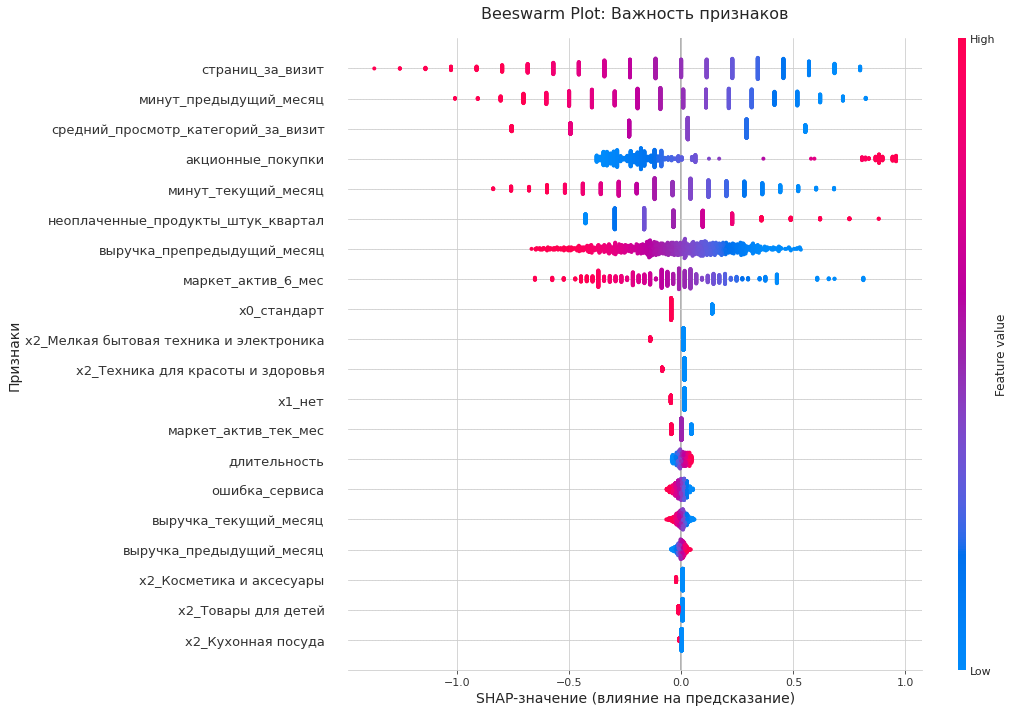

In [95]:
fig, ax = plt.subplots(figsize=(15,10))  

shap.plots.beeswarm(explanation, show=False, plot_size=(15,10), max_display=20)

ax.set_title("Beeswarm Plot: Важность признаков", fontsize=16, pad=20)
ax.set_xlabel("SHAP-значение (влияние на предсказание)", fontsize=14)
ax.set_ylabel("Признаки", fontsize=14)

plt.tight_layout() 
plt.show()

In [96]:
df_final.columns

Index(['id', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц',
       'выручка_текущий_месяц', 'минут_предыдущий_месяц',
       'минут_текущий_месяц', 'покупательская_активность', 'тип_сервиса',
       'разрешить_сообщать', 'маркет_актив_6_мес', 'маркет_актив_тек_мес',
       'длительность', 'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'вероятность_снижения_покуп_акт%'],
      dtype='object')

### Вывод

- Наше предположении выдвинутое на этапе исследовательского анализа подтвердилось. Самым важным фактором предсказывающим будущие снижение покупательской активности выступают : **минут_предыдущий_месяц, минут_предыдущий_месяц, средний_просмотр_категорий_за_визит и акционные_покупки**


## Сегментация покупателей

Для начала добавим в наш датасет присланные заказчиком данные о среднемесячной прибыли.

In [97]:
df_seg = pd.merge(df_final, df_money, on='id', how='outer')
df_seg.head(5)

,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,вероятность_снижения_покуп_акт%,прибыль
0,215349,5216.0,4472.0,4971.6,12.0,10.0,Снизилась,премиум,да,4.4,4.0,819.0,0.75,Товары для детей,4.0,4.0,2.0,5.0,80.53,4.16
1,215350,5457.5,4826.0,5058.4,8.0,13.0,Снизилась,стандарт,нет,4.9,3.0,539.0,0.14,Домашний текстиль,5.0,2.0,1.0,5.0,38.79,3.13
2,215351,6158.0,4793.0,6610.4,11.0,13.0,Снизилась,стандарт,да,3.2,5.0,896.0,0.99,Товары для детей,5.0,0.0,6.0,4.0,67.72,4.87
3,215352,5807.5,4594.0,5872.5,8.0,11.0,Снизилась,стандарт,нет,5.1,3.0,1064.0,0.94,Товары для детей,3.0,2.0,3.0,2.0,87.04,4.21
4,215353,4738.5,5124.0,5388.5,10.0,10.0,Снизилась,стандарт,да,3.3,4.0,762.0,0.26,Домашний текстиль,4.0,1.0,1.0,4.0,55.05,3.95


Видим что данные о прибыли к представлены в сокращенном виде. Создадим дополнительную переменную где приведем значения к классическому для нашего датасета виду.

In [98]:
df_seg['прибыль_1000'] = df_seg['прибыль'] * 1000
df_seg['прибыль_1000'].head(5)

0    4160.0
1    3130.0
2    4870.0
3    4210.0
4    3950.0
Name: прибыль_1000, dtype: float64

### Создадие "группы риска" на основании предсказания модели.

Для создании группы будем возьмём значения двух целевых параметров : *вероятность_снижения_покуп_акт% > 70* и *выручку* выше медианного значения.

Таким образом мы выделим группу высокодоходных покупателей которых компания не хочет потерять в первую очередь.

In [99]:
df_seg['прибыль_1000'].median()

4045.0

In [100]:
df_risk = df_seg[(df_seg['прибыль_1000'] > 4045) & (df_seg['вероятность_снижения_покуп_акт%'] > 70)]
display(df_risk.shape)
df_risk.head(5)

(166, 21)

,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,...,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,вероятность_снижения_покуп_акт%,прибыль,прибыль_1000
0,215349,5216.0,4472.0,4971.6,12.0,10.0,Снизилась,премиум,да,4.4,...,819.0,0.75,Товары для детей,4.0,4.0,2.0,5.0,80.53,4.16,4160.0
3,215352,5807.5,4594.0,5872.5,8.0,11.0,Снизилась,стандарт,нет,5.1,...,1064.0,0.94,Товары для детей,3.0,2.0,3.0,2.0,87.04,4.21,4210.0
7,215356,4146.5,4433.0,4566.4,6.0,7.0,Снизилась,стандарт,да,4.2,...,192.0,0.14,Косметика и аксесуары,2.0,2.0,1.0,3.0,84.05,4.93,4930.0
17,215368,5823.0,4536.0,5591.6,11.0,9.0,Снизилась,премиум,да,3.8,...,829.0,0.24,Техника для красоты и здоровья,2.0,2.0,6.0,1.0,81.32,6.27,6270.0
23,215374,5762.5,4666.0,5720.9,11.0,8.0,Снизилась,стандарт,нет,2.9,...,268.0,0.98,Домашний текстиль,6.0,3.0,2.0,2.0,83.53,4.08,4080.0


На этапе анализа данных мы заметили что , пользователи разделились на две группы по параметру **акционные_покупки** , посмотрим на это значение в разрезе сформированной нами группы.

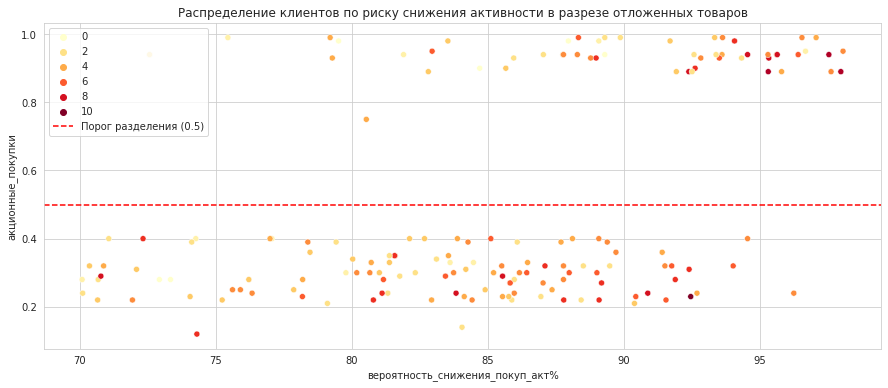

In [101]:
plt.figure(figsize=(15, 6))
sns.scatterplot(
    data=df_risk,
    x="вероятность_снижения_покуп_акт%",
    y="акционные_покупки",
    hue="неоплаченные_продукты_штук_квартал",
    alpha=1,
    palette="YlOrRd"
)
# plt.axvline(70, color="gray", linestyle="--", label="Порог риска (70%)")
plt.axhline(0.5, color="red", linestyle="--", label="Порог разделения (0.5)")
plt.title("Распределение клиентов по риску снижения активности в разрезе отложенных товаров")
plt.legend()
plt.show()

Посмотрим на то как распределились предпочитаемые категории в нашей группе "риска".

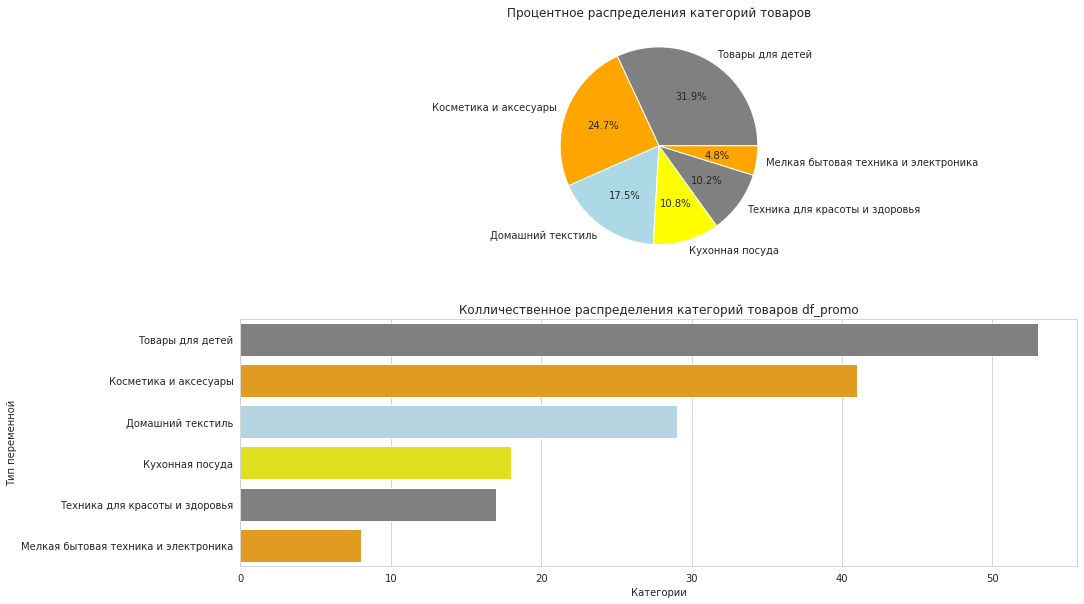

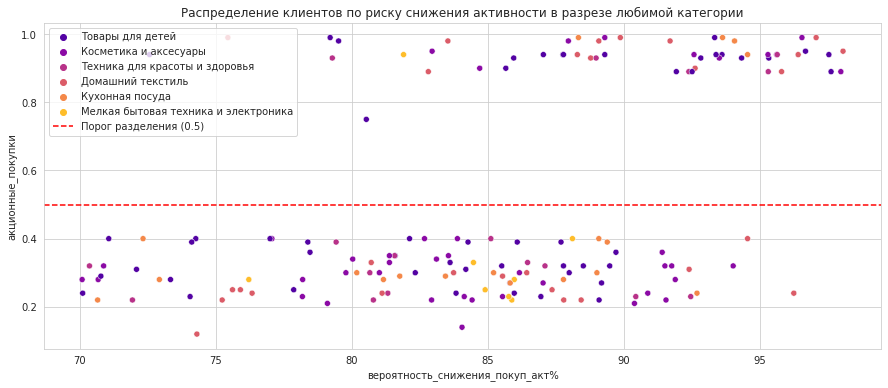

In [102]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

df_risk['популярная_категория'].value_counts().plot(kind='pie', y='count', x='популярная_категория',
                           colors=['grey', 'orange', 'lightblue', 'yellow'],ax=ax[0], autopct='%1.1f%%')
ax[0].set_title('Процентное распределения категорий товаров')
ax[0].set_ylabel(' ')

order = df_risk['популярная_категория'].value_counts().index

sns.countplot(data=df_risk, 
             y='популярная_категория',  
             order=order,  
             palette=['grey', 'orange', 'lightblue', 'yellow'],
             ax=ax[1])
    
ax[1].set_title('Колличественное распределения категорий товаров df_promo')
ax[1].set_xlabel('Категории')
ax[1].set_ylabel('Тип переменной');
plt.show()

plt.figure(figsize=(15, 6))
sns.scatterplot(
    data=df_risk,
    x="вероятность_снижения_покуп_акт%",
    y="акционные_покупки",
    hue="популярная_категория",
    alpha=1,
    palette="plasma"
)
# plt.axvline(70, color="gray", linestyle="--", label="Порог риска (70%)")
plt.axhline(0.5, color="red", linestyle="--", label="Порог разделения (0.5)")
plt.title("Распределение клиентов по риску снижения активности в разрезе любимой категории")
plt.legend()
plt.show()

### Выводы и рекомендации по блоку.


- На основании работы модели и проведенного на этапе исследовательского анализа данных , мы создали "группу риска" и рассмотрели ее в разрезе "акционной активности" "отложенных товаров" и "любимой категории" 


**Рекомендации**

Для повышения покупательской активности группы :

- Ввести новый параметр который будет отображать кол-во отложенных в корзину товаров в текущем месяце и при достижении определенного количества , покупателю направлялась персональная скидка на один из товаров в корзине , а так же ему поступало бы оповещение об этом событии что как раз бы повысило кол-во коммуникацией с нашей группой.


- Так же в нашей группе , оказалось всего лишь пару клиентов с акционной активностью ниже 20% , что говорит нам о том что для предотвращения ухода клиента , можно использовать персональные акции для любимой категории клиента. Так же проведение общих акций в категориях **детских товаром и косметики** могло бы положительно сказаться на покупательской активности группы.


## Общий вывод

К нам обратился интернет магазин «В один клик» , с задачей построить модель, которая предскажет вероятность снижения покупательской активности клиента , а так же выделить сегменты покупателей и разработать для них персонализированные предложения. Вот какие шаги мы проделали :


- От заказчика нам поступило 4 таблицы , содержащие информацию о поведении покупателя на сайте , данными о выручке, которую получает магазин с покупателя , с данные о времени (в минутах), которое покупатель провёл на сайте , а так же данные о среднемесячной прибыли продавца за последние 3 месяца. Мы привели все данные во всех датафреймах к единому формату отображения , а так же устранили орфографические опечатки в некоторых переменных , которые удалось выявить на этапе ознакомления с данными. Так же нами были изменены типы данных в некоторых переменных.


- Мы провели анализ всех переменных представленных в данных , никаких явных аномалий обнаружено не было , в большинстве случаев данные распределены нормально , а так же не наблюдалось явного дисбаланса классов в данных. Так же мы выдвинули несколько предроложений которые должны будут быть проверенны предсказаниями модели МО.


- Так же мы провели корреляционный анализ данных , в ходе которого не была обнаружена мультиколинеальность и поэтому для обучения модели использовались все доступные нам признаки.


- На этапе построения модели МО нами был применен метод "пайплайн" который выполнил перебор 4 моделей МО с разными значениями гиперпараметров. Победителем стала модель использующая алгоритм *LogisticRegression* со следующими тонкими настройками (C=0.01, penalty='l2', solver='liblinear') по метрике "accuracy" она показала аналогичный модели SVC результат и за за простоты интерпретации результатов и была выбрана.


- Мы создали "группу риска" куда вошли клиенты с достаточно высоким показателем приносимой прибыли и риском снижения активности больше 70% по предсказанию модели. Воспользовавшись выводами сделанными на этапе исследовательского анализа мы проанализировали эту группу в разрезе "акционных покупок" "отложенных товаров" и "любимой категории". Для удержания покупательской активности , рекомендуется ввести новый признак "количество отложенных товаров в месяц" и при достижении определённого порога покупателю направлялась бы персональная скидка на один из товаров в его корзине , а так же для покупателей с "индексом акционной активности" более 0.5 проведение персонализированных скидочных акций с персональным уведомлением о них.


- Так же среди всех покупателей выделелись группы товаров "детские товары" и "косметика", проведение скидочных акций , а так же реклама на главной странице в этих группах вместе с рекомендациями товаров из других категорий и комбо предложений , возможно могло бы повысить посещаемость сайта а так же повлиять на получаемую выручку и удержание интереса к интернет-магазину.

